In [12]:
'''
Prepare parameters for model based on deisgn and measurement conditions
Unit: mm
Author: Yitian Shao
Created on 2022.01.17
'''
# %matplotlib notebook 
# %matplotlib notebook 

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

plt.rcParams.update({'font.size': 14})

from PouchLib import getEpsilon0 

try:
    EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity
except:
    EPSILON0 = 0.0000000000088541878128

calib = np.loadtxt('Calibration20210802.txt')
print("Calibration line a = %.16f, b = %.16f" % (calib[0],calib[1]))

Fs = 1000 # Sampling frequency of all measurements

Calibration line a = 0.0497649079931161, b = 0.1217075926746309


In [2]:
''' Condition table '''
# Layout: %d - number of dashes dividing rectangle column, T - extra triangle column, - R - an extra rectangle cell
colNames = ['CondiName','Shell','ls_um','Fluid','Infill_mL','DashLength_mm','FlatDashDist_mm','DashSpace_mm','Layout',
            'triNum','rectNum','TubeLength_mm','TubeInnerDia_mm','VoltPolar','Voltage_V','HVSupply','Info']
condiTable = [
    ['6mLBOPP12',           'BOPP',20,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLBOPP16',           'BOPP',20,'IC',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLL0Ws12SoftTube','PETL0Ws',30,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,4,'Uni',8800,'Wearable','20210719_SoftTube'],
    ['BOPP16ShiftedU7kV',   'BOPP',20,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210729_RigidTube'],
    ['L0Ws16ShiftedU9kV','PETL0Ws',30,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['L0Ws16NoShift',    'PETL0Ws',30,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['Mylar16',            'Mylar',15,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['Mylar16NoShift',     'Mylar',15,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16',              'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP20',              'BOPP',20,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16U9kV',          'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210728_RigidTube'],
    ['MLSi16SB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16S'],
    ['MLSi16CB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16C'],
    ['MLSi20SB7kV',  'Mylar',15,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_20S'],
    ['MLSi20B7kV',   'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube'],
    ['Tube6mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,35,6-2,'Bi',6900,'Wearable','20210924'],
    ['MedTubePressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['PressBalloon2',      'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['Tube8mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['Pressure',           'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['FR3Tube8mm',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20211008'],
    ['FR3MedTube',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['SiMedTube',    'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['L0WsSi5-20Trek8kV',      'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',8000,'Trek','20220302'],
    ['L0WsSi5-20Trek9kV',      'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi5-20Trek10kV',     'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi6-16Trek9kVHVTop', 'L0Ws',20,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi6-16Trek10kVHVTop','L0Ws',20,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi5-20sTrek9kVHVBot','L0Ws',20,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,4.0,'Bi',9000,'Trek','20220302'],
    ['MLSi20HV7kV.5Hz',       'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV1Hz',        'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402']
]

''' For frequency comparison exclusively (2022.04.02)'''
condiTable = [
    ['MLSi20HV7kV10mL.5Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL1Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL2Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL4Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL10Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL20Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402']
]

condiTable = pd.DataFrame(condiTable, columns = colNames)
condiTable.to_csv("ConditionTable.csv", index=False)

colNames2 = ['Material','DieConstant','DieStrength_V/um','Density_kg/m3','Viscosity_mm2/s']
materialProperty = [['BOPP',2.2,700,float('nan'),float('nan')],['Mylar',3.2,276,float('nan'),float('nan')],
                    ['L0Ws',3,float('nan'),float('nan'),float('nan')],
                    ['IC',3.2,20,920,34],['Silicone',2.6,15,920,5]]
materialProperty = pd.DataFrame(materialProperty, columns = colNames2)
materialProperty.to_csv("MaterialProperty.csv", index=False)

In [3]:
'''
General Functions
'''

def aPlot(figName='', is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassFilter(datain, cutFreq, Fs, order):
    b, a = signal.butter(order, 2 * cutFreq / Fs, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeFileName(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    return condi, names, trialNum

def decodeFileName2(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    print(names)
    freq = None
    freqInfo = re.findall('[\.]*\d+Hz', names)
    if freqInfo:
        freq = float(re.split('Hz', freqInfo[0])[0])
        print("Signal frequency (Hz) = %.3f" % freq)
    
    return condi, names, trialNum, freq

''' Identify pressure increasing duration and compute time-averaged pressure '''
def processPressure(rawData, Fs, inactivePressure, cutOff=5, order=8):   
    print(rawData.shape)
    print(np.max(rawData))
    filtData = lowpassFilter(rawData, cutOff, Fs, order) - inactivePressure
        
    maxFiltPress = np.max(filtData) 
    print(maxFiltPress)
    
    samp = np.arange(len(rawData))
    ax0, _ = aPlot("Truncat")
    ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
    ax0.plot(samp, filtData, color='tab:blue')
    
    zipStart = samp[0]
    zipEnd = samp[-1]
    
    try:
        zipStart = np.nonzero(filtData > 0.25 * maxFiltPress)[0][0]
        ax0.plot([zipStart,zipStart], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the start of zipping process")

    try:
        zipEnd = np.argmax(filtData)
        ax0.plot([zipEnd,zipEnd], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the end of zipping process")
        
    plt.show()
    
    avgPressure = np.mean(rawData[zipStart:zipEnd+1] - inactivePressure)
    
    deltaT = (zipEnd - zipStart) / Fs
    
    maxPressure = rawData[zipEnd] - inactivePressure # Maximum steady state pressure
    peakPressure = np.max(rawData) - inactivePressure # Peak pressure reachable
    
    return avgPressure, deltaT, peakPressure, np.array([zipStart, zipEnd])

''' 
(For different signal frequency of repeated measurement) 
Identify pressure increasing duration and compute time-averaged pressure 
'''
def cutRepeatTrial(rawData, Fs, inactivePressure, cutOff=5, order=8): 
    print(rawData.shape)
    maxRawValue = np.max(rawData)
    print("max value of raw data = %.3f" % maxRawValue)
    filtData = lowpassFilter(rawData, cutOff, Fs, order) - inactivePressure
    
    samp = np.arange(len(rawData))
    
    maxFiltPress = np.max(filtData) 
    print(maxFiltPress)
    
    segPointInd = np.squeeze(np.argwhere(filtData > 0.25 * maxFiltPress)) # Find value larger than 25% of peak as valid segment data point
    
    segGapInd = np.squeeze(np.argwhere(np.diff(segPointInd) > 1))# Index of point where large gap occurs (end and start of a seg)
    print(segPointInd[segGapInd]) # End index of a segment
    print(segPointInd[segGapInd+1]) # Start index of a segment
    
    cutInd = (0.5 * (segPointInd[segGapInd] + segPointInd[segGapInd+1])).astype(int) # Cut in the middle of a end and a start point
    
    avgSegLen = np.mean(np.diff(cutInd))
    print("Avg. segment length = %d" % avgSegLen)
    
    cutInd = np.insert(cutInd, 0, max(cutInd[0]-avgSegLen, 0))
    
    ''' Plot data segmentation index '''
#     ax0, _ = aPlot("Cut Segments")
#     ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
#     ax0.plot(samp[segPointInd], filtData[segPointInd], color='tab:blue')
#     ax0.plot(cutInd, np.zeros(cutInd.shape), '*g')
#     plt.show()
    return cutInd


In [4]:
''' Design and zipping state '''
colNames3 = ['Layout','triNum','rectNum','triNum1Expan','rectNum1Expan','triNum2Expan','rectNum2Expan']

stateLayout = [
    ['6T5T4T3T2T1T', 48,27, -12,-6, -23,-12],
    ['5T4T3T2T1TRT', 36,21, -12,-6, -21,-11],
    ['T5T4T3T2T1', 45,20, -10,-5, -20,-10],
    ['T5T4T3T2T1TR', 48,21, -12,-6, -23,-11],
    ['5T4T3T2T1T', 37,20, -10,-5, -19,-10],
    ['T5T4T3T2T', 45,18, -10,-4, -19,-8]
]

stateLayout = pd.DataFrame(stateLayout, columns = colNames3)
stateLayout.to_csv("StateLayout.csv", index=False)


In [ ]:
''' Generate model by matched parameters after getting model data of Valid Arc Length '''
md = pd.read_csv("./data/ValidArcLength.csv")
dataLen = md.shape[0]
print("Data contains %d rows" % dataLen)

''' Get total volume of design structures for inactive and zipped state '''
stateLayout = pd.read_csv("./data/StateLayout.csv")
stateLayout.head()

''' Compute total volume based on pouch design and zipping state '''
for layout_i in stateLayout['Layout']:
    ind = (stateLayout['Layout'] == layout_i)
    md[layout_i] = stateLayout.loc[ind,'triNum'].iloc[0] * md['triVol'] + stateLayout.loc[ind,'rectNum'].iloc[0] * md['rectVol']

md.to_csv("ValidArcLength.csv", index=False)
md.head(1)    

In [ ]:
'''Measurement 2022 Duel Trial'''
pressData = []
Fs = 1000
beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)

for root, directories, files in walk(".\data\DualTrial"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum = decodeFileName(fileName)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])

                for i in range(len(beginInd)): 
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                    P0 = data[beginInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa


MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.12340150878318715
0.11704415563219545


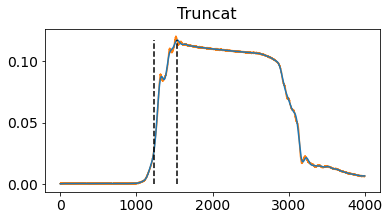


MLSi20HV7kV1Hz - Trial01 - Seg1
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.120 (bar) in 0.150 (sec)

(4000,)
0.11504579193153253
0.11075886342942895


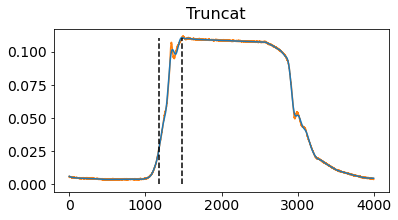


MLSi20HV7kV1Hz - Trial01 - Seg2
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.112 (bar) in 0.150 (sec)

(4000,)
0.12532605009258938
0.11854960864517668


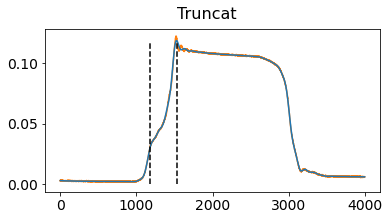


MLSi20HV7kV1Hz - Trial01 - Seg3
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.122 (bar) in 0.175 (sec)

(4000,)
0.1066098858586528
0.10062912456725852


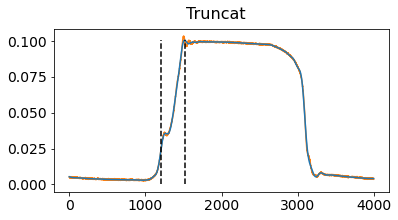


MLSi20HV7kV1Hz - Trial01 - Seg4
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.103 (bar) in 0.153 (sec)

(4000,)
0.10014663462791036
0.09513012946021138


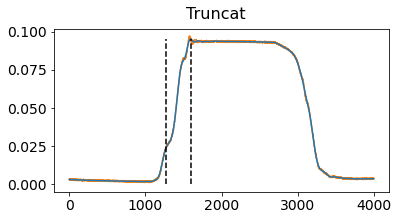


MLSi20HV7kV1Hz - Trial01 - Seg5
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.097 (bar) in 0.162 (sec)

(4000,)
0.1260477530836152
0.11771053788963727


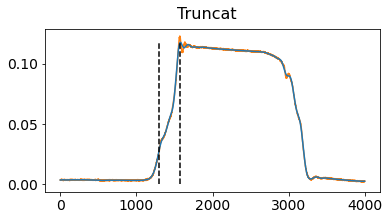


MLSi20HV7kV1Hz - Trial01 - Seg6
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.123 (bar) in 0.138 (sec)

(4000,)
0.1094646221342661
0.10528637078762378


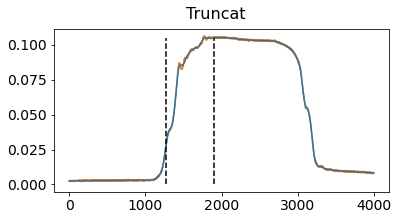


MLSi20HV7kV1Hz - Trial01 - Seg7
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.106 (bar) in 0.316 (sec)

(4000,)
0.11453258091569193
0.10612757593067554


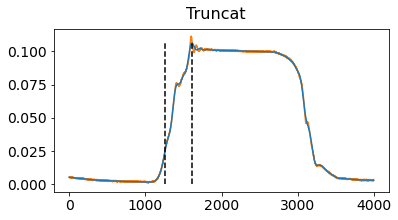


MLSi20HV7kV1Hz - Trial01 - Seg8
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.111 (bar) in 0.175 (sec)

(4000,)
0.10927216800332587
0.10429075358580607


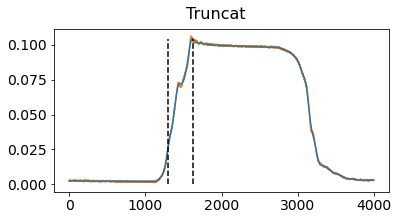


MLSi20HV7kV1Hz - Trial01 - Seg9
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.106 (bar) in 0.162 (sec)

(4000,)
0.10620893975252735
0.1017996335362668


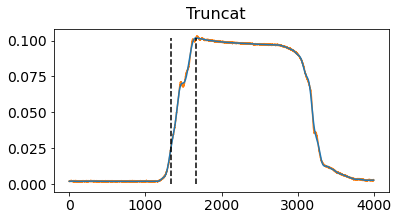


MLSi20HV7kV1Hz - Trial01 - Seg10
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.103 (bar) in 0.165 (sec)

(4000,)
0.10710705903024838
0.10197642797728886


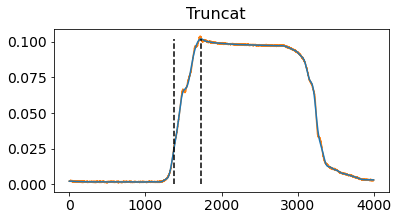


MLSi20HV7kV1Hz - Trial01 - Seg11
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.104 (bar) in 0.177 (sec)

(4000,)
0.10556742598272661
0.10074191889877356


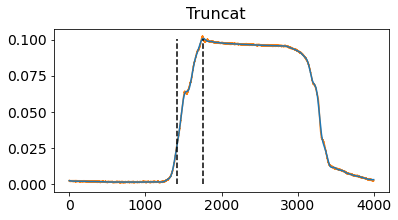


MLSi20HV7kV1Hz - Trial01 - Seg12
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.102 (bar) in 0.175 (sec)

(4000,)
0.10636931819497754
0.10146534143107645


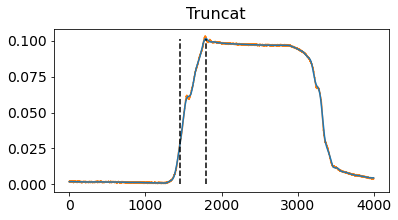


MLSi20HV7kV1Hz - Trial01 - Seg13
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.103 (bar) in 0.173 (sec)

(4000,)
0.10389949018124468
0.09999158545983837


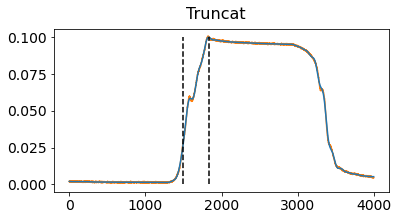


MLSi20HV7kV1Hz - Trial01 - Seg14
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.101 (bar) in 0.170 (sec)

(4000,)
0.10693064274355318
0.1030357859363905


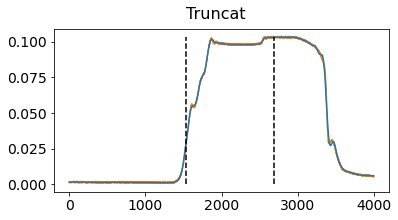


MLSi20HV7kV1Hz - Trial01 - Seg15
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.104 (bar) in 0.582 (sec)

(4000,)
0.11400333205560632
0.10710257984275141


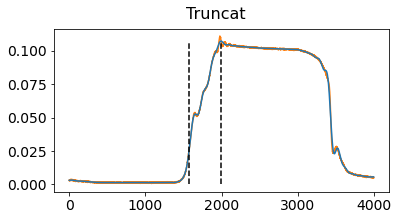


MLSi20HV7kV1Hz - Trial01 - Seg16
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.111 (bar) in 0.208 (sec)

(4000,)
0.1169382575524447
0.10876380888781509


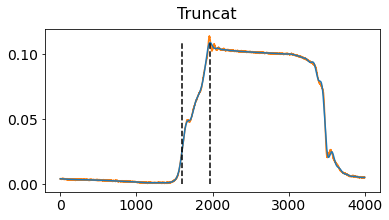


MLSi20HV7kV1Hz - Trial01 - Seg17
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.114 (bar) in 0.183 (sec)

(4000,)
0.11292879649119009
0.10438451296168054


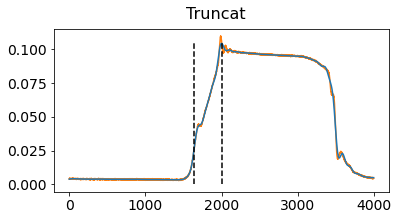


MLSi20HV7kV1Hz - Trial01 - Seg18
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.110 (bar) in 0.180 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.11583164629953843
0.11225746612519126


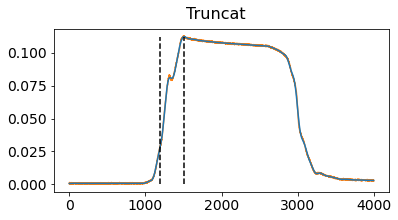


MLSi20HV7kV1Hz - Trial02 - Seg1
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.113 (bar) in 0.158 (sec)

(4000,)
0.11005802237133178
0.10557607460208883


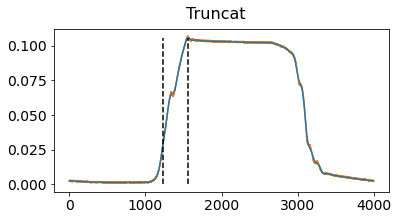


MLSi20HV7kV1Hz - Trial02 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.107 (bar) in 0.169 (sec)

(4000,)
0.11134104991093326
0.10696109089649426


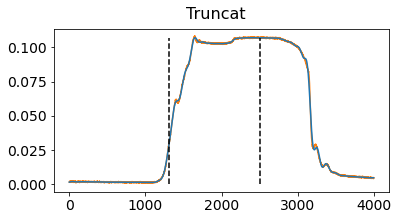


MLSi20HV7kV1Hz - Trial02 - Seg3
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.108 (bar) in 0.602 (sec)

(4000,)
0.11963261538560781
0.11382989579048748


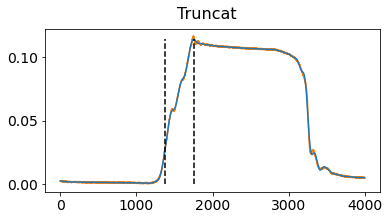


MLSi20HV7kV1Hz - Trial02 - Seg4
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.116 (bar) in 0.186 (sec)

(4000,)
0.12107602136765948
0.11267218614133256


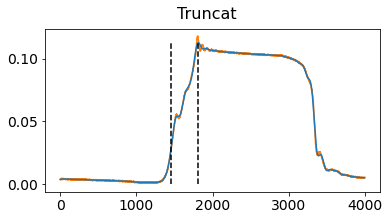


MLSi20HV7kV1Hz - Trial02 - Seg5
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.118 (bar) in 0.179 (sec)

(4000,)
0.11461277013691702
0.1062846027969292


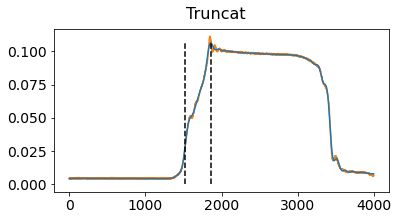


MLSi20HV7kV1Hz - Trial02 - Seg6
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.111 (bar) in 0.170 (sec)

(4000,)
0.11102029302603289
0.10469276602734394


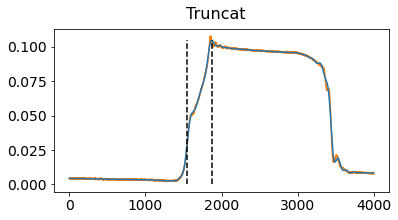


MLSi20HV7kV1Hz - Trial02 - Seg7
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.108 (bar) in 0.165 (sec)

(4000,)
0.1098976439288816
0.10470824542013525


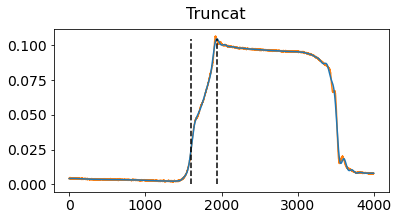


MLSi20HV7kV1Hz - Trial02 - Seg8
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.107 (bar) in 0.169 (sec)

(4000,)
0.1083419730371148
0.10398070038718692


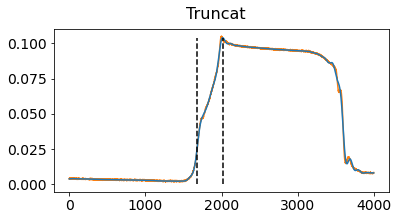


MLSi20HV7kV1Hz - Trial02 - Seg9
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.105 (bar) in 0.168 (sec)

(4000,)
0.10709102118600336
0.10322748480518437


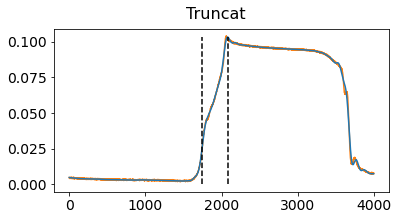


MLSi20HV7kV1Hz - Trial02 - Seg10
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.104 (bar) in 0.167 (sec)

(4000,)
0.10442873904133029
0.10159541121062113


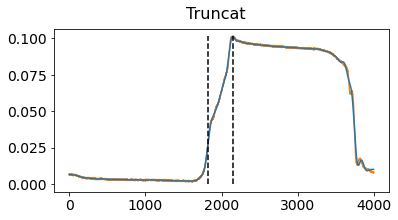


MLSi20HV7kV1Hz - Trial02 - Seg11
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.167 (sec)

(4000,)
0.10107682959412144
0.09852958822614281


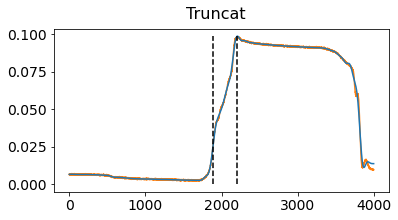


MLSi20HV7kV1Hz - Trial02 - Seg12
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.098 (bar) in 0.162 (sec)

(4000,)
0.10199098671608749
0.0965656292010594


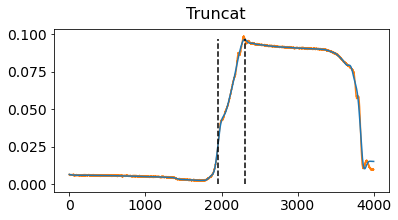


MLSi20HV7kV1Hz - Trial02 - Seg13
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.099 (bar) in 0.178 (sec)

(4000,)
0.10420420922190003
0.09798059765336689


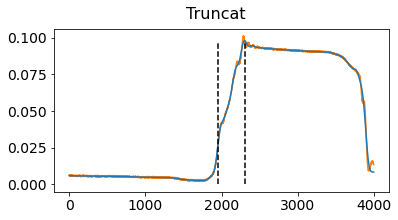


MLSi20HV7kV1Hz - Trial02 - Seg14
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.177 (sec)

(4000,)
0.10418817137765501
0.09752673494450156


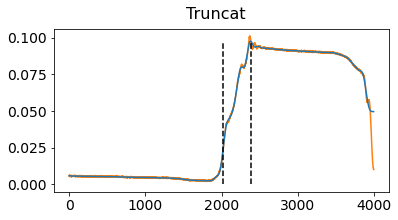


MLSi20HV7kV1Hz - Trial02 - Seg15
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.179 (sec)

(4000,)
0.10442873904133029
0.09808117183164689


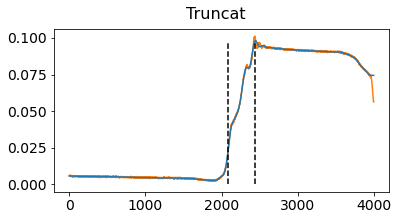


MLSi20HV7kV1Hz - Trial02 - Seg16
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.178 (sec)

(4000,)
0.10369099820605944
0.09762231968683667


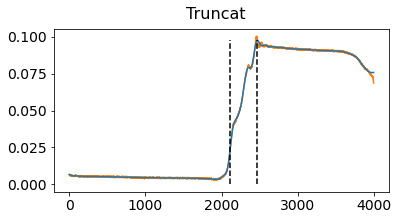


MLSi20HV7kV1Hz - Trial02 - Seg17
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.100 (bar) in 0.178 (sec)

(4000,)
0.10157400276571701
0.0962558176227653


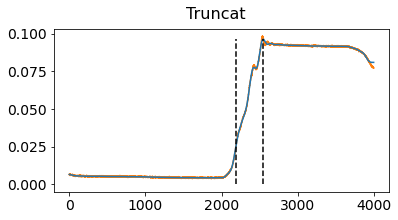


MLSi20HV7kV1Hz - Trial02 - Seg18
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.098 (bar) in 0.180 (sec)

MLSi20HV7kV.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.1125920017620447
0.10951379700771537


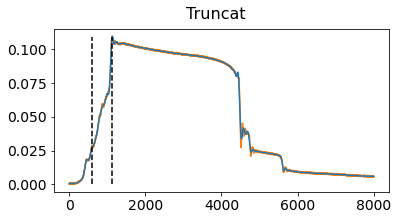


MLSi20HV7kV.5Hz - Trial03 - Seg1
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.110 (bar) in 0.270 (sec)

(8000,)
0.1106033090756624
0.09963440372233211


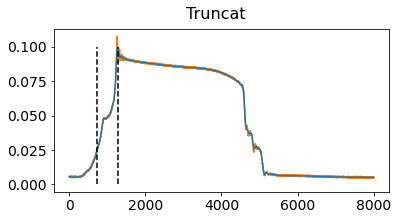


MLSi20HV7kV.5Hz - Trial03 - Seg2
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.108 (bar) in 0.270 (sec)

(8000,)
0.100707959176486
0.090766854198889


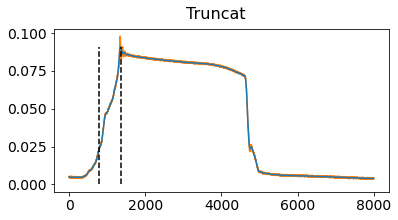


MLSi20HV7kV.5Hz - Trial03 - Seg3
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.098 (bar) in 0.284 (sec)

(8000,)
0.09049185239240924
0.0833002058442519


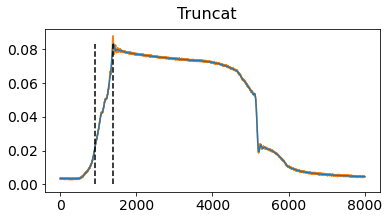


MLSi20HV7kV.5Hz - Trial03 - Seg4
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.088 (bar) in 0.247 (sec)

(8000,)
0.08114178919756347
0.07190846475630651


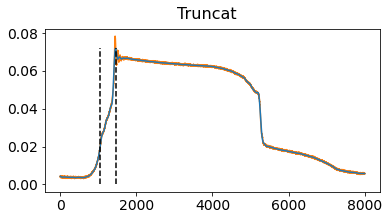


MLSi20HV7kV.5Hz - Trial03 - Seg5
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.078 (bar) in 0.209 (sec)

(8000,)
0.0669322591964771
0.061575910372417136


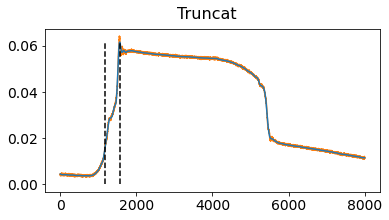


MLSi20HV7kV.5Hz - Trial03 - Seg6
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.064 (bar) in 0.195 (sec)

(8000,)
0.05580199529043428
0.05066211961444913


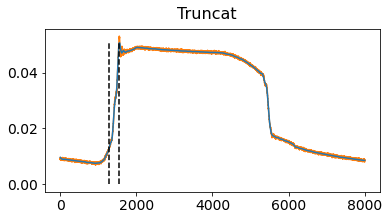


MLSi20HV7kV.5Hz - Trial03 - Seg7
Avg. Pressure of zipping = 0.027 (bar), Max. P. = 0.053 (bar) in 0.141 (sec)

(8000,)
0.04864911675715604
0.042551316022579576


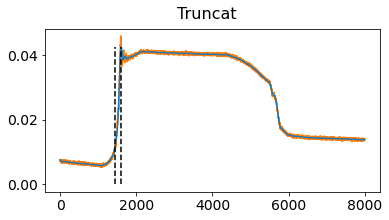


MLSi20HV7kV.5Hz - Trial03 - Seg8
Avg. Pressure of zipping = 0.024 (bar), Max. P. = 0.046 (bar) in 0.085 (sec)

(8000,)
0.04528116946570216
0.04185004796151824


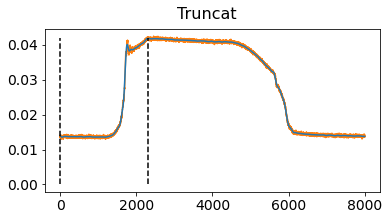


MLSi20HV7kV.5Hz - Trial03 - Seg9
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.157 (sec)

(8000,)
0.0459226832355029
0.042339603514040265


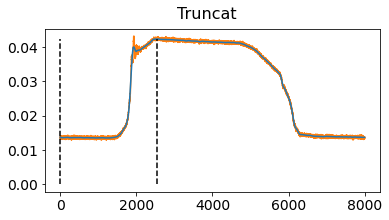


MLSi20HV7kV.5Hz - Trial03 - Seg10
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.272 (sec)

(8000,)
0.04598683461248297
0.04258645025847471


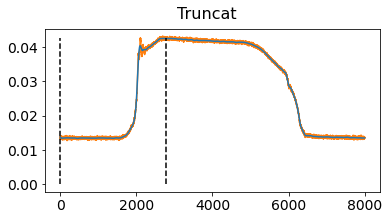


MLSi20HV7kV.5Hz - Trial03 - Seg11
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.387 (sec)

(8000,)
0.04704533233265419
0.04300676252352458


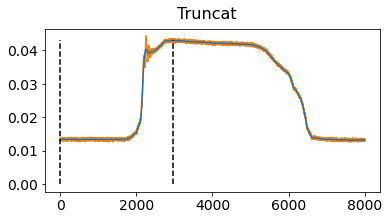


MLSi20HV7kV.5Hz - Trial03 - Seg12
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.044 (bar) in 1.478 (sec)

(8000,)
0.04651608347256858
0.04311052926057473


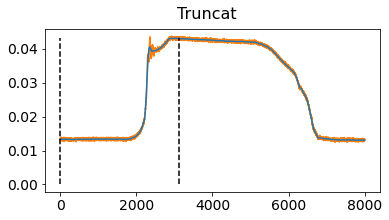


MLSi20HV7kV.5Hz - Trial03 - Seg13
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.044 (bar) in 1.558 (sec)

(8000,)
0.04717363508661434
0.043282111027120165


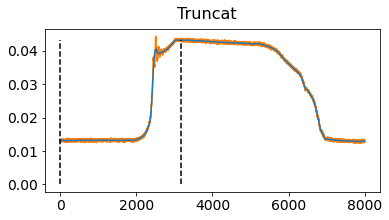


MLSi20HV7kV.5Hz - Trial03 - Seg14
Avg. Pressure of zipping = 0.020 (bar), Max. P. = 0.044 (bar) in 1.591 (sec)

(8000,)
0.04691702957869404
0.0434457023629664


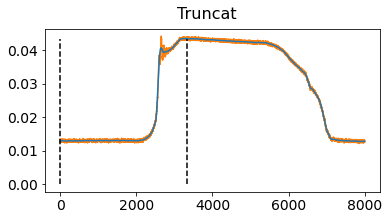


MLSi20HV7kV.5Hz - Trial03 - Seg15
Avg. Pressure of zipping = 0.020 (bar), Max. P. = 0.044 (bar) in 1.667 (sec)

(8000,)
0.04771892179094497
0.043524037773117454


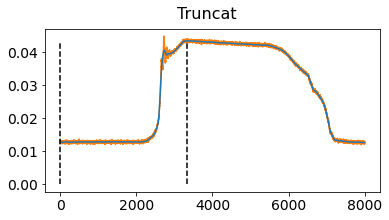


MLSi20HV7kV.5Hz - Trial03 - Seg16
Avg. Pressure of zipping = 0.019 (bar), Max. P. = 0.045 (bar) in 1.671 (sec)

(8000,)
0.04770288394669995
0.04361789615804651


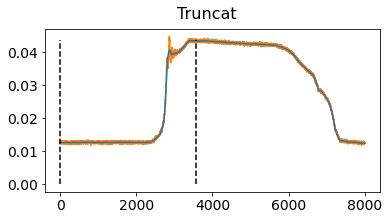


MLSi20HV7kV.5Hz - Trial03 - Seg17
Avg. Pressure of zipping = 0.019 (bar), Max. P. = 0.045 (bar) in 1.778 (sec)

(8000,)
0.04751042981575973
0.043490037181539376


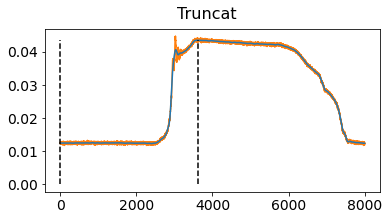


MLSi20HV7kV.5Hz - Trial03 - Seg18
Avg. Pressure of zipping = 0.018 (bar), Max. P. = 0.045 (bar) in 1.806 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.08197575709830443
0.07181859184938892


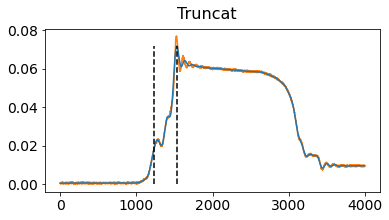


MLSi20HV7kV1Hz - Trial04 - Seg1
Avg. Pressure of zipping = 0.034 (bar), Max. P. = 0.077 (bar) in 0.150 (sec)

(4000,)
0.06625866973818632
0.06010959434732606


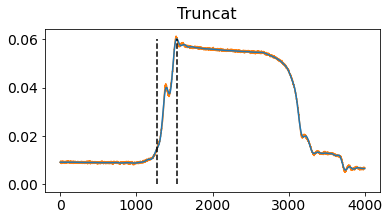


MLSi20HV7kV1Hz - Trial04 - Seg2
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.061 (bar) in 0.128 (sec)

(4000,)
0.06425393920755902
0.05776572140975074


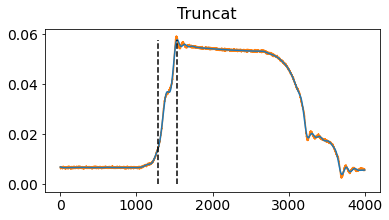


MLSi20HV7kV1Hz - Trial04 - Seg3
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.059 (bar) in 0.125 (sec)

(4000,)
0.06095014329308521
0.054427230823658315


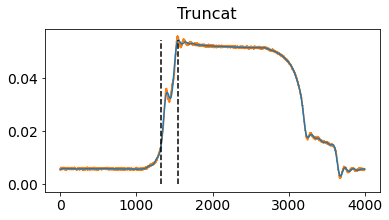


MLSi20HV7kV1Hz - Trial04 - Seg4
Avg. Pressure of zipping = 0.035 (bar), Max. P. = 0.056 (bar) in 0.116 (sec)

(4000,)
0.05740577971493613
0.05218523501874313


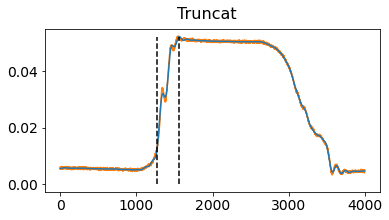


MLSi20HV7kV1Hz - Trial04 - Seg5
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.052 (bar) in 0.144 (sec)

(4000,)
0.05771049875559148
0.05232965674262066


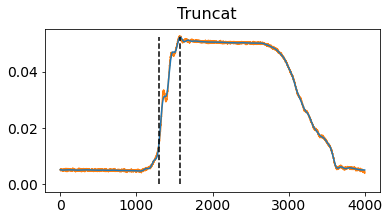


MLSi20HV7kV1Hz - Trial04 - Seg6
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.142 (sec)

(4000,)
0.05493595170120328
0.049853919779709974


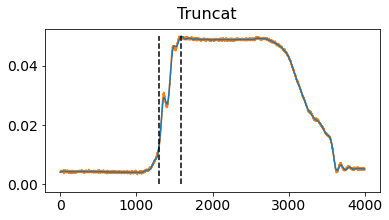


MLSi20HV7kV1Hz - Trial04 - Seg7
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.050 (bar) in 0.147 (sec)

(4000,)
0.056555773969950145
0.05173029355312207


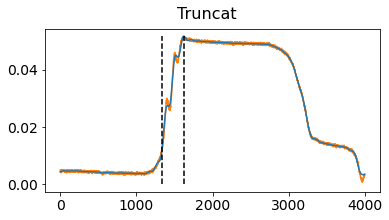


MLSi20HV7kV1Hz - Trial04 - Seg8
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.052 (bar) in 0.141 (sec)

(4000,)
0.057534082468896276
0.05124949820150679


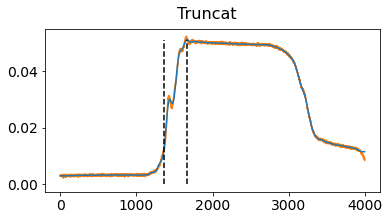


MLSi20HV7kV1Hz - Trial04 - Seg9
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.052 (bar) in 0.150 (sec)

(4000,)
0.05758219600163133
0.05156958779411677


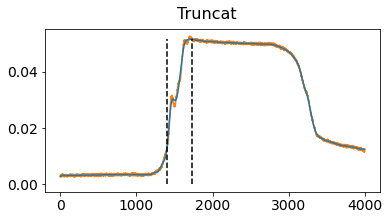


MLSi20HV7kV1Hz - Trial04 - Seg10
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.165 (sec)

(4000,)
0.05820767192718705
0.051785428564115846


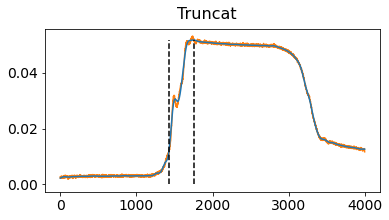


MLSi20HV7kV1Hz - Trial04 - Seg11
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.160 (sec)

(4000,)
0.05886522354123281
0.05236731315043382


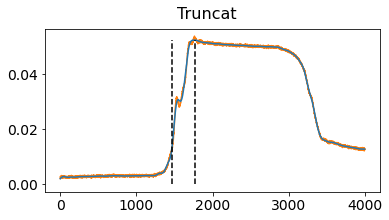


MLSi20HV7kV1Hz - Trial04 - Seg12
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.054 (bar) in 0.151 (sec)

(4000,)
0.05899352629519296
0.05266255774667028


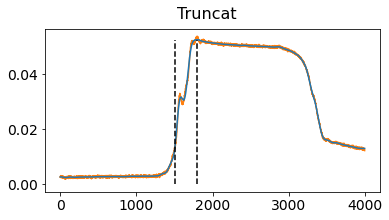


MLSi20HV7kV1Hz - Trial04 - Seg13
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.054 (bar) in 0.147 (sec)

(4000,)
0.0587689964757627
0.05288798757493453


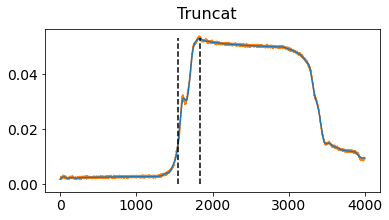


MLSi20HV7kV1Hz - Trial04 - Seg14
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.054 (bar) in 0.145 (sec)

(4000,)
0.05775861228832654
0.05266430004444954


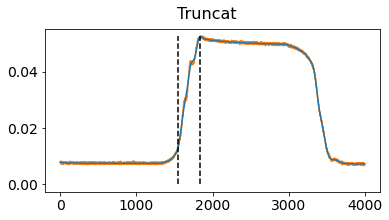


MLSi20HV7kV1Hz - Trial04 - Seg15
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.146 (sec)

(4000,)
0.05852842881208742
0.05292676661472159


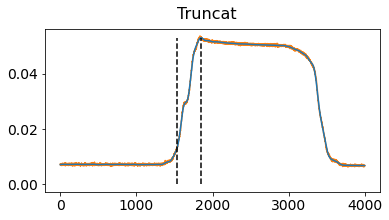


MLSi20HV7kV1Hz - Trial04 - Seg16
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.157 (sec)

(4000,)
0.058303898992657165
0.052795556624578674


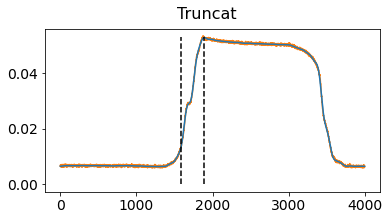


MLSi20HV7kV1Hz - Trial04 - Seg17
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.153 (sec)

(4000,)
0.05862465587755753
0.05274000191634297


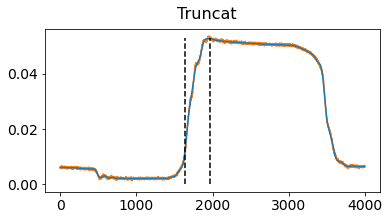


MLSi20HV7kV1Hz - Trial04 - Seg18
Avg. Pressure of zipping = 0.041 (bar), Max. P. = 0.054 (bar) in 0.165 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.1111967093127281
0.10774621887157387


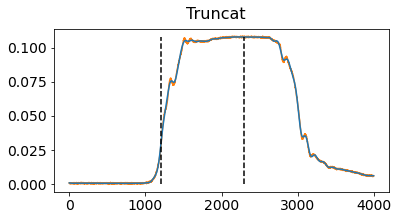


MLSi20HV7kV1Hz - Trial05 - Seg1
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.108 (bar) in 0.545 (sec)

(4000,)
0.11785241467441077
0.1133595396825308


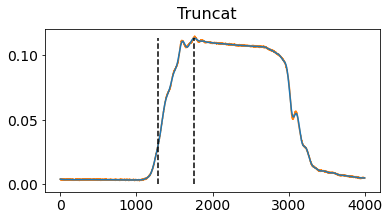


MLSi20HV7kV1Hz - Trial05 - Seg2
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.115 (bar) in 0.242 (sec)

(4000,)
0.11045896847745725
0.10680748099723097


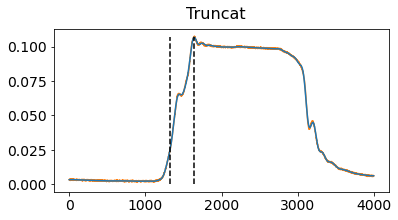


MLSi20HV7kV1Hz - Trial05 - Seg3
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.108 (bar) in 0.156 (sec)

(4000,)
0.08373991996525647
0.08050362221350618


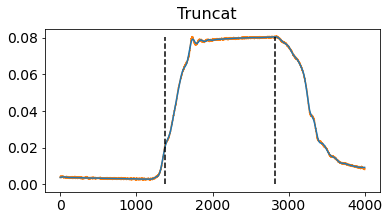


MLSi20HV7kV1Hz - Trial05 - Seg4
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.081 (bar) in 0.726 (sec)

(4000,)
0.08502294750485793
0.08145686661806843


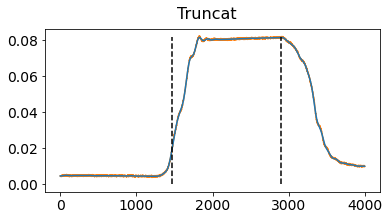


MLSi20HV7kV1Hz - Trial05 - Seg5
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.082 (bar) in 0.716 (sec)

(4000,)
0.08968996018015832
0.08533048990275315


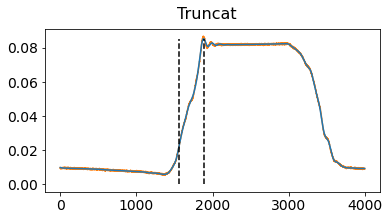


MLSi20HV7kV1Hz - Trial05 - Seg6
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.087 (bar) in 0.164 (sec)

(4000,)
0.09066826867910445
0.08641241323468202


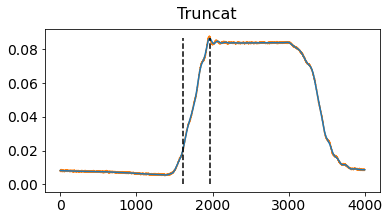


MLSi20HV7kV1Hz - Trial05 - Seg7
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.088 (bar) in 0.172 (sec)

(4000,)
0.09260884783275168
0.08864178830903902


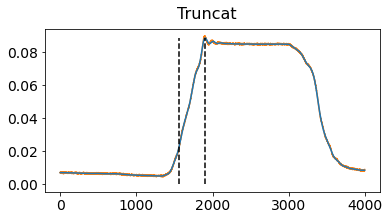


MLSi20HV7kV1Hz - Trial05 - Seg8
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.090 (bar) in 0.173 (sec)

(4000,)
0.09472584327309412
0.09082168338265567


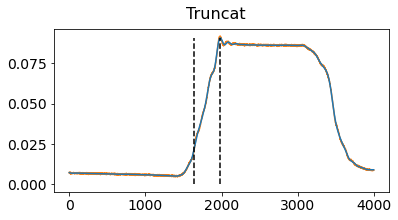


MLSi20HV7kV1Hz - Trial05 - Seg9
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.092 (bar) in 0.171 (sec)

(4000,)
0.09634566554184099
0.09236567388831748


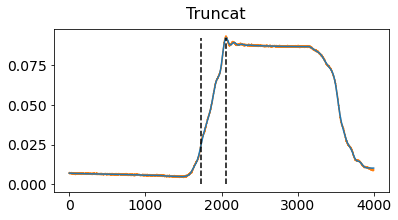


MLSi20HV7kV1Hz - Trial05 - Seg10
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.093 (bar) in 0.169 (sec)

(4000,)
0.09620132494363581
0.09226963407060344


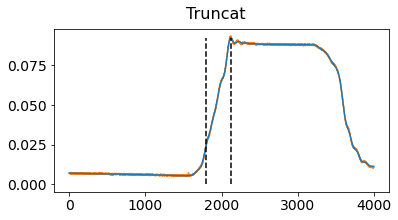


MLSi20HV7kV1Hz - Trial05 - Seg11
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.093 (bar) in 0.165 (sec)

(4000,)
0.10022682384913545
0.09597044084914091


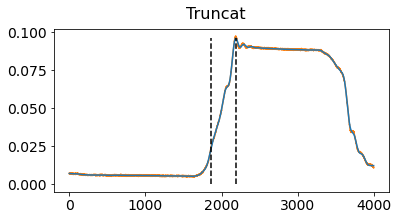


MLSi20HV7kV1Hz - Trial05 - Seg12
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.097 (bar) in 0.162 (sec)

(4000,)
0.10215136515853768
0.09746785542400091


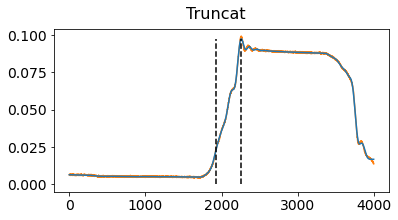


MLSi20HV7kV1Hz - Trial05 - Seg13
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.099 (bar) in 0.163 (sec)

(4000,)
0.0955758490180801
0.09130877314725543


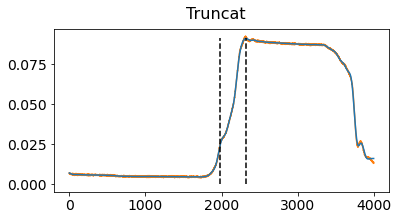


MLSi20HV7kV1Hz - Trial05 - Seg14
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.093 (bar) in 0.173 (sec)

(4000,)
0.09843058529369339
0.0941519180193803


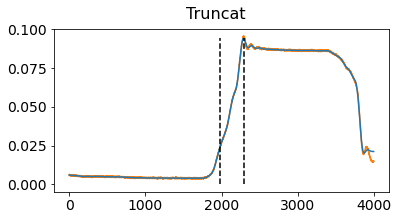


MLSi20HV7kV1Hz - Trial05 - Seg15
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.096 (bar) in 0.157 (sec)

(4000,)
0.09677868733645649
0.09269853145408272


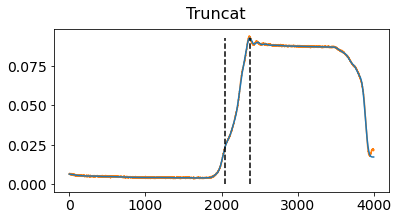


MLSi20HV7kV1Hz - Trial05 - Seg16
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.094 (bar) in 0.164 (sec)

(4000,)
0.09676264949221146
0.09304496761721388


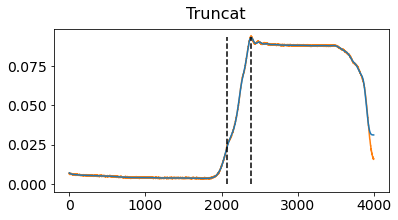


MLSi20HV7kV1Hz - Trial05 - Seg17
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.094 (bar) in 0.160 (sec)

(4000,)
0.09642585476306607
0.09232470791850478


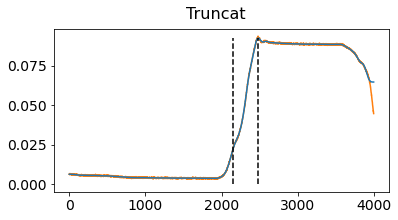


MLSi20HV7kV1Hz - Trial05 - Seg18
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.094 (bar) in 0.163 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.12524586087136427
0.11440354083667635


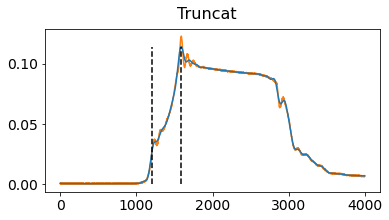


MLSi20HV7kV1Hz - Trial06 - Seg1
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.123 (bar) in 0.191 (sec)

(4000,)
0.13121193893051114
0.12461769276112894


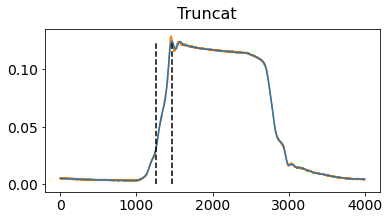


MLSi20HV7kV1Hz - Trial06 - Seg2
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.129 (bar) in 0.104 (sec)

(4000,)
0.09358715633169781
0.09013054196184474


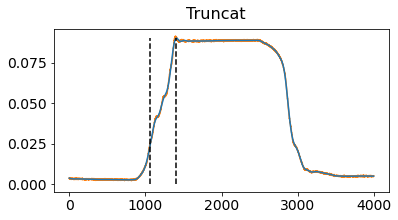


MLSi20HV7kV1Hz - Trial06 - Seg3
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.091 (bar) in 0.176 (sec)

(4000,)
0.09820605547426313
0.09552156727724972


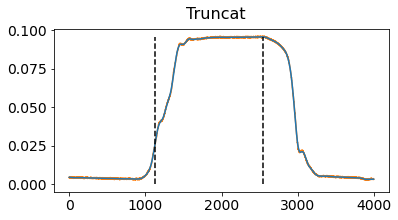


MLSi20HV7kV1Hz - Trial06 - Seg4
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.096 (bar) in 0.711 (sec)

(4000,)
0.11127689853395319
0.10868797474673944


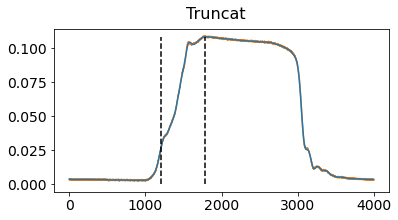


MLSi20HV7kV1Hz - Trial06 - Seg5
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.109 (bar) in 0.289 (sec)

(4000,)
0.1250854824289141
0.1174904281131849


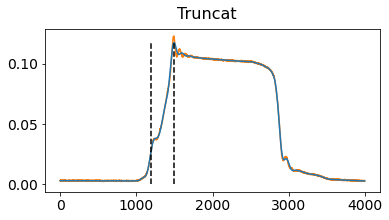


MLSi20HV7kV1Hz - Trial06 - Seg6
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.123 (bar) in 0.148 (sec)

(4000,)
0.12696191020558126
0.11752161787782109


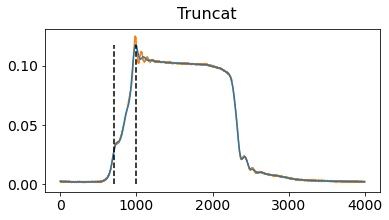


MLSi20HV7kV1Hz - Trial06 - Seg7
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.125 (bar) in 0.140 (sec)

(4000,)
0.1263043585915355
0.1177286220544128


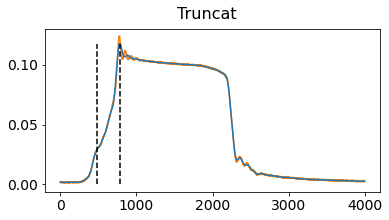


MLSi20HV7kV1Hz - Trial06 - Seg8
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.124 (bar) in 0.147 (sec)

(4000,)
0.12051469681908383
0.1147684053754253


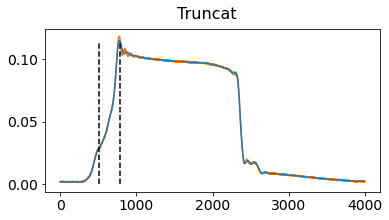


MLSi20HV7kV1Hz - Trial06 - Seg9
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.118 (bar) in 0.136 (sec)

(4000,)
0.12421943883968309
0.11545748323492994


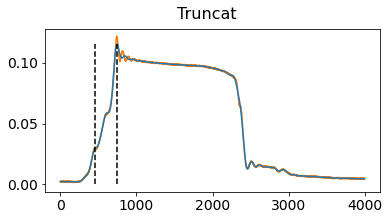


MLSi20HV7kV1Hz - Trial06 - Seg10
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.122 (bar) in 0.147 (sec)

(4000,)
0.11132501206668824
0.10724632024783366


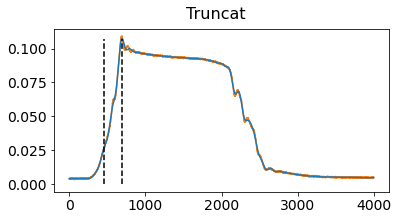


MLSi20HV7kV1Hz - Trial06 - Seg11
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.109 (bar) in 0.119 (sec)

(4000,)
0.09543150841987494
0.09193539119098912


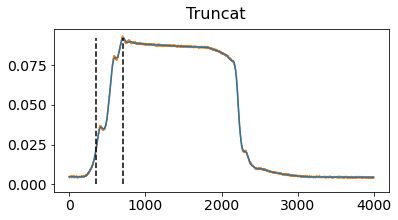


MLSi20HV7kV1Hz - Trial06 - Seg12
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.093 (bar) in 0.176 (sec)

(4000,)
0.09607302218967567
0.0933119684484494


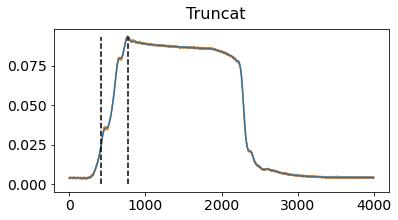


MLSi20HV7kV1Hz - Trial06 - Seg13
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.094 (bar) in 0.178 (sec)

(4000,)
0.0941805565687635
0.0919807169681357


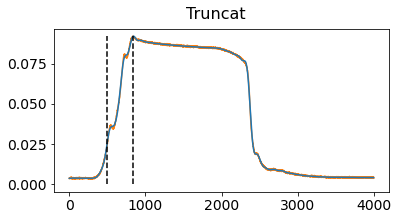


MLSi20HV7kV1Hz - Trial06 - Seg14
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.092 (bar) in 0.176 (sec)

(4000,)
0.09337866435651257
0.09103878156563062


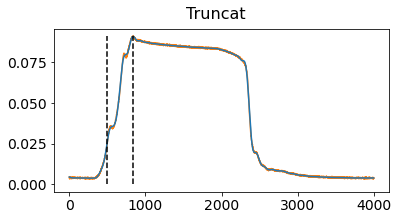


MLSi20HV7kV1Hz - Trial06 - Seg15
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.091 (bar) in 0.174 (sec)

(4000,)
0.09169469071078562
0.08912099770282854


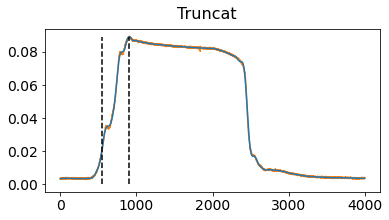


MLSi20HV7kV1Hz - Trial06 - Seg16
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.089 (bar) in 0.177 (sec)

(4000,)
0.09029939826146902
0.08794109227038395


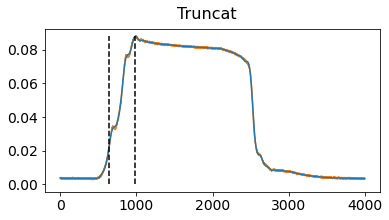


MLSi20HV7kV1Hz - Trial06 - Seg17
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.088 (bar) in 0.173 (sec)

(4000,)
0.092881491184917
0.0903005741368056


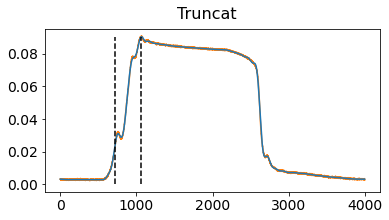


MLSi20HV7kV1Hz - Trial06 - Seg18
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.091 (bar) in 0.175 (sec)



In [13]:
'''Measurement 2022 Twenty Trial (Act4 Act6)'''
pressData = []
Fs = 2000

'''
Shifted0.5s: 1-3, 5-7, 9-11, ...
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77]
'''

for root, directories, files in walk(".\Data220401Relabelled\ValidData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum, sigFreq = decodeFileName2(fileName)
                
                trialArray = np.arange(1, 40, 2.22)/sigFreq
                beginInd = (Fs * np.array(0.1 + trialArray)).astype(int)
                endInd = (Fs * np.array(0.1 + 2/sigFreq + trialArray)).astype(int)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])
                
#                 ax, _ = aPlot()
#                 ax.plot(data)
#                 ax.plot(beginInd, np.zeros(beginInd.shape), '*r')
#                 ax.plot(endInd, np.zeros(endInd.shape), '*g')
#                 plt.show()

                for i in range(len(beginInd)): 
#                     ax.plot(beginInd[i]+np.arange(len(data[beginInd[i]:endInd[i]])), data[beginInd[i]:endInd[i]])
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, 
                                                                               inactivePressure, 20, 8)
                    P0 = data[beginInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd, sigFreq]) # 1 bar = 100 kPa
                    
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex', 'SigFreq'])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv")

MLSi20HV7kV10mL.5Hz
Signal frequency (Hz) = 0.500
(164000,)
max value of raw data = 0.167
0.14486693691590977
[  8545  17505  26480  35434  44412  53314  62328  71322  80242  89212
  98208 107200 116160 125039 134081 143122 152010]
[ 13895  22848  31815  40782  49718  58650  67696  76694  85576  94587
 103586 112526 121471 130428 139439 148419 157401]
Avg. segment length = 8967
(8968,)
0.13858934728321964
0.1248100120232275


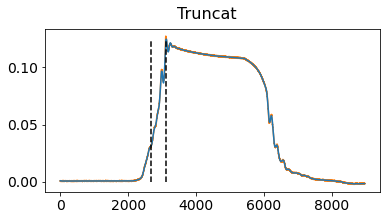


MLSi20HV7kV10mL.5Hz - Trial13 - Seg1
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.127 (bar) in 0.224 (sec)

(8956,)
0.12676945607464105
0.11501238556368892


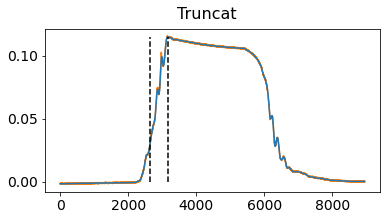


MLSi20HV7kV10mL.5Hz - Trial13 - Seg2
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.116 (bar) in 0.266 (sec)

(8971,)
0.12633643428002553
0.11493484449930605


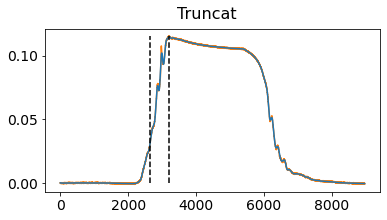


MLSi20HV7kV10mL.5Hz - Trial13 - Seg3
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.115 (bar) in 0.288 (sec)

(8961,)
0.12697794804982626
0.11534218261136894


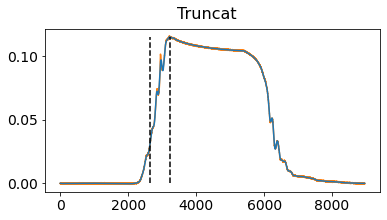


MLSi20HV7kV10mL.5Hz - Trial13 - Seg4
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.116 (bar) in 0.295 (sec)

(8957,)
0.12635247212427056
0.11467093590627303


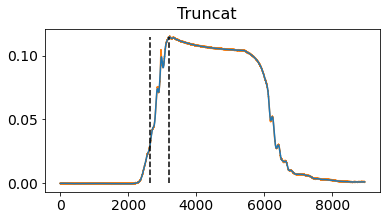


MLSi20HV7kV10mL.5Hz - Trial13 - Seg5
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.115 (bar) in 0.288 (sec)

(8917,)
0.13302421533019823
0.11441451448785508


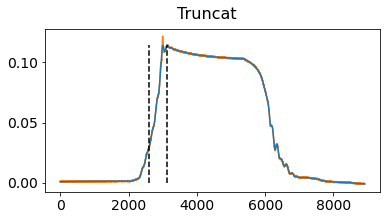


MLSi20HV7kV10mL.5Hz - Trial13 - Seg6
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.122 (bar) in 0.272 (sec)

(9030,)
0.1279562565487724
0.11626273955736391


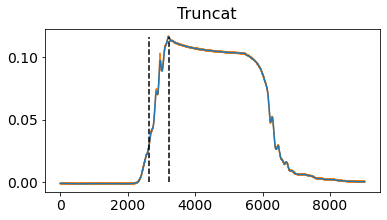


MLSi20HV7kV10mL.5Hz - Trial13 - Seg7
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.117 (bar) in 0.290 (sec)

(8996,)
0.12564680697748973
0.11374711373666799


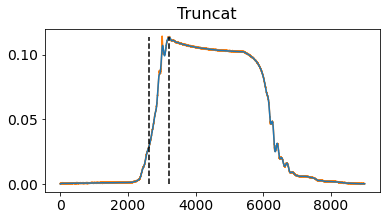


MLSi20HV7kV10mL.5Hz - Trial13 - Seg8
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.115 (bar) in 0.300 (sec)

(8901,)
0.12591945032965504
0.11264787032090791


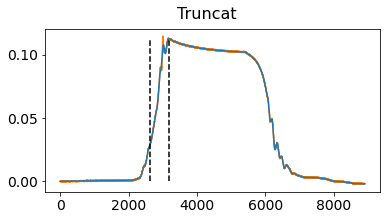


MLSi20HV7kV10mL.5Hz - Trial13 - Seg9
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.115 (bar) in 0.277 (sec)

(8990,)
0.1270741751152964
0.1155035158728678


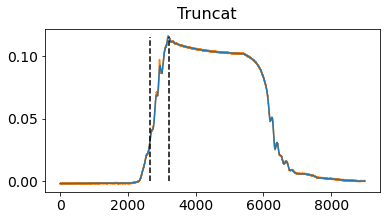


MLSi20HV7kV10mL.5Hz - Trial13 - Seg10
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.116 (bar) in 0.281 (sec)

(8998,)
0.12587133679692
0.11242580275691667


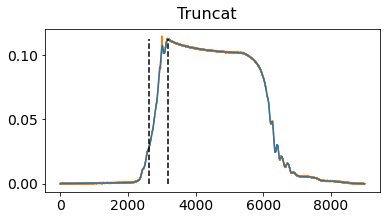


MLSi20HV7kV10mL.5Hz - Trial13 - Seg11
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.115 (bar) in 0.280 (sec)

(8966,)
0.16652727195804184
0.14412465884275918


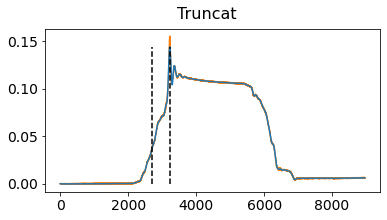


MLSi20HV7kV10mL.5Hz - Trial13 - Seg12
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.155 (bar) in 0.266 (sec)

(8952,)
0.15247812039940564
0.1377061910560293


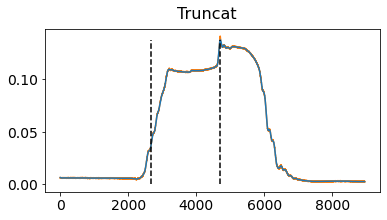


MLSi20HV7kV10mL.5Hz - Trial13 - Seg13
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.141 (bar) in 1.027 (sec)

(8918,)
0.15558946218293923
0.14221286945595435


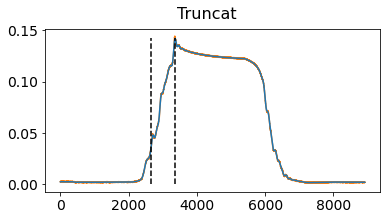


MLSi20HV7kV10mL.5Hz - Trial13 - Seg14
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.144 (bar) in 0.353 (sec)

(9027,)
0.15828382001610233
0.14321397994803722


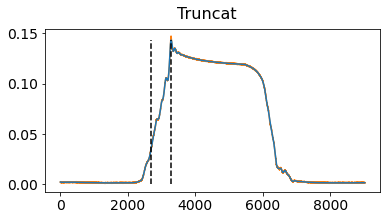


MLSi20HV7kV10mL.5Hz - Trial13 - Seg15
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.147 (bar) in 0.295 (sec)

(9010,)
0.1559102190678396
0.14041115411736896


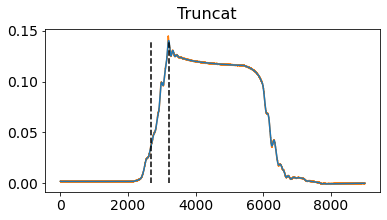


MLSi20HV7kV10mL.5Hz - Trial13 - Seg16
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.145 (bar) in 0.267 (sec)

(8935,)
0.16017628563701453
0.1436924196722305


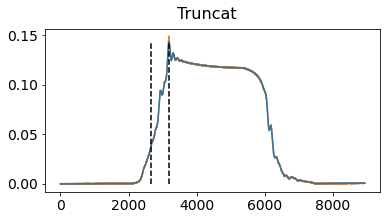


MLSi20HV7kV10mL.5Hz - Trial13 - Seg17
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.149 (bar) in 0.271 (sec)

MLSi20HV7kV10mL1Hz
Signal frequency (Hz) = 1.000
(82000,)
max value of raw data = 0.175
0.16556349861315117
[ 5296  9788 14218 18699 23190 27662 32136 36535 41026 45483 49958 54435
 58912 63382 67797 72284 76760]
[ 7934 12419 16897 21387 25847 30321 34786 39202 43678 48165 52643 57091
 61608 66076 70465 74934 79409]
Avg. segment length = 4466
(4467,)
0.1748188374327164
0.16556165631759062


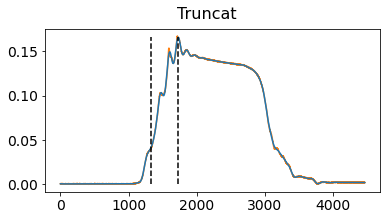


MLSi20HV7kV10mL1Hz - Trial14 - Seg1
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.167 (bar) in 0.199 (sec)

(4488,)
0.16019232348125953
0.1450113172758982


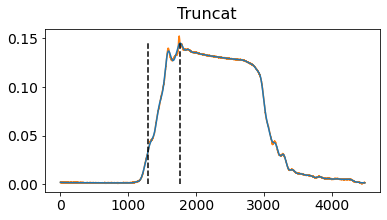


MLSi20HV7kV10mL1Hz - Trial14 - Seg2
Avg. Pressure of zipping = 0.100 (bar), Max. P. = 0.152 (bar) in 0.234 (sec)

(4454,)
0.1600800585715444
0.14520639927047185


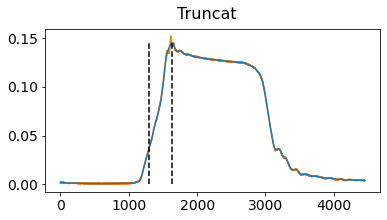


MLSi20HV7kV10mL1Hz - Trial14 - Seg3
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.152 (bar) in 0.169 (sec)

(4486,)
0.15728947367291118
0.14409918938058358


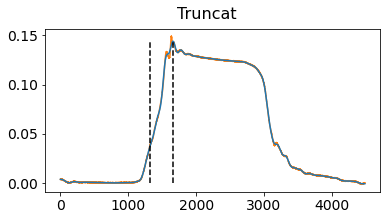


MLSi20HV7kV10mL1Hz - Trial14 - Seg4
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.149 (bar) in 0.172 (sec)

(4475,)
0.13616763280222186
0.12230253986855577


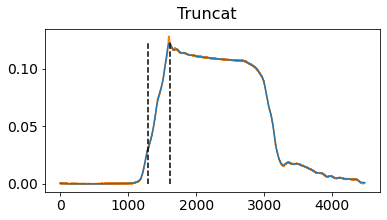


MLSi20HV7kV10mL1Hz - Trial14 - Seg5
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.128 (bar) in 0.158 (sec)

(4473,)
0.13422705364857462
0.12148144509582187


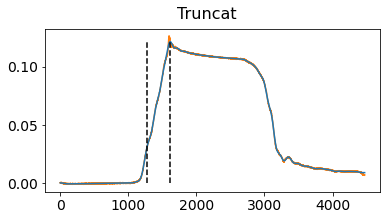


MLSi20HV7kV10mL1Hz - Trial14 - Seg6
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.126 (bar) in 0.172 (sec)

(4470,)
0.16679991531020716
0.15274443435779445


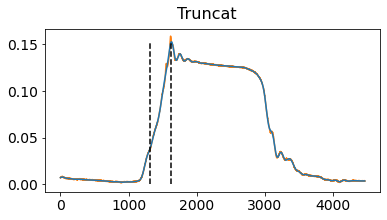


MLSi20HV7kV10mL1Hz - Trial14 - Seg7
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.159 (bar) in 0.157 (sec)

(4407,)
0.15531681883077392
0.14114741072332376


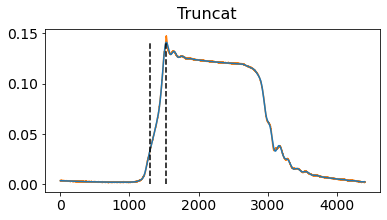


MLSi20HV7kV10mL1Hz - Trial14 - Seg8
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.147 (bar) in 0.116 (sec)

(4484,)
0.1445554253423665
0.13688491076160827


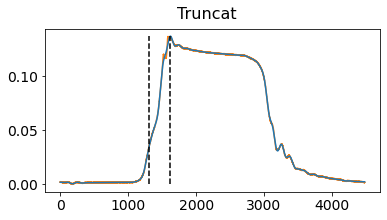


MLSi20HV7kV10mL1Hz - Trial14 - Seg9
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.137 (bar) in 0.158 (sec)

(4472,)
0.1390544447663252
0.1319463293190056


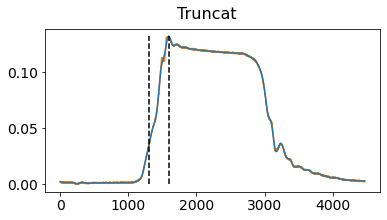


MLSi20HV7kV10mL1Hz - Trial14 - Seg10
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.131 (bar) in 0.148 (sec)

(4476,)
0.15796306313120195
0.1448904795158685


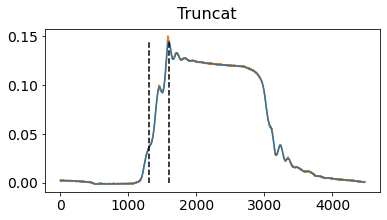


MLSi20HV7kV10mL1Hz - Trial14 - Seg11
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.150 (bar) in 0.145 (sec)

(4463,)
0.1385412337504846
0.12430011407039371


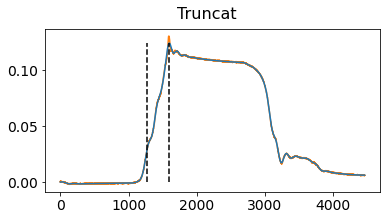


MLSi20HV7kV10mL1Hz - Trial14 - Seg12
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.131 (bar) in 0.160 (sec)

(4497,)
0.15730551151715622
0.14215510630551234


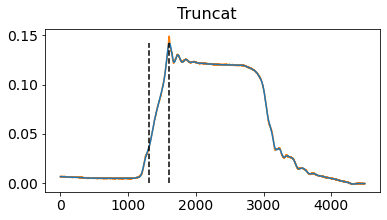


MLSi20HV7kV10mL1Hz - Trial14 - Seg13
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.149 (bar) in 0.152 (sec)

(4469,)
0.15255830962063074
0.13884659590798284


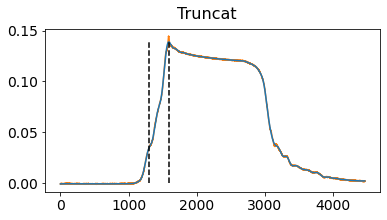


MLSi20HV7kV10mL1Hz - Trial14 - Seg14
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.145 (bar) in 0.144 (sec)

(4402,)
0.13571857316336133
0.12095334702205823


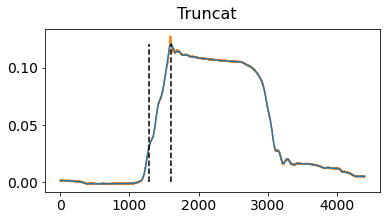


MLSi20HV7kV10mL1Hz - Trial14 - Seg15
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.128 (bar) in 0.161 (sec)

(4478,)
0.13292798826472813
0.11819167647025786


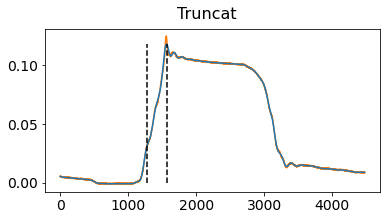


MLSi20HV7kV10mL1Hz - Trial14 - Seg16
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.125 (bar) in 0.147 (sec)

(4475,)
0.1598234530636241
0.14467808333977455


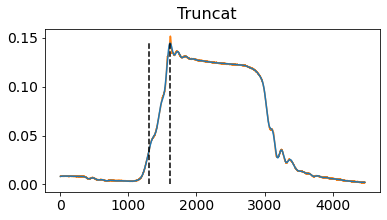


MLSi20HV7kV10mL1Hz - Trial14 - Seg17
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.152 (bar) in 0.153 (sec)

MLSi20HV7kV10mL2Hz
Signal frequency (Hz) = 2.000
(41000,)
max value of raw data = 0.181
0.16336610292411913
[ 3655  5908  8169 10434 12688 14953 17203 19455 21720 23973 26220 28424
 30682 32937 35187 37440]
[ 4999  7256  9507 11774 14033 16286 18539 20793 23056 25307 27503 29757
 32019 34273 36525 38771]
Avg. segment length = 2251
(2252,)
0.1811698237537437
0.16336710995461945


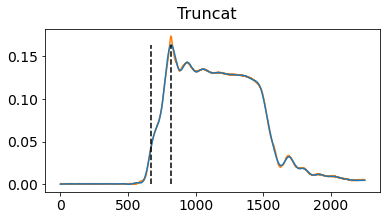


MLSi20HV7kV10mL2Hz - Trial16 - Seg1
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.174 (bar) in 0.075 (sec)

(2255,)
0.1564394679279252
0.14614387233623982


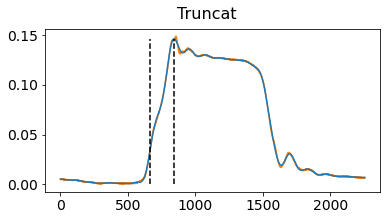


MLSi20HV7kV10mL2Hz - Trial16 - Seg2
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.149 (bar) in 0.087 (sec)

(2256,)
0.15283095297279606
0.1430037984117823


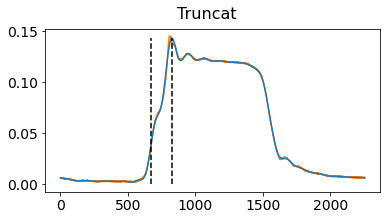


MLSi20HV7kV10mL2Hz - Trial16 - Seg3
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.145 (bar) in 0.079 (sec)

(2266,)
0.17470657252300126
0.1579990092240874


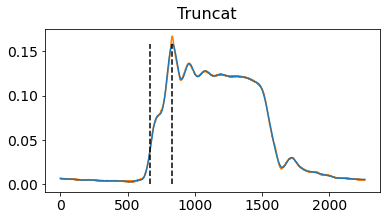


MLSi20HV7kV10mL2Hz - Trial16 - Seg4
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.167 (bar) in 0.083 (sec)

(2256,)
0.15647154361641524
0.14396275187671853


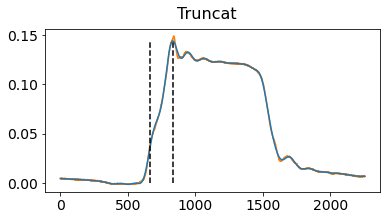


MLSi20HV7kV10mL2Hz - Trial16 - Seg5
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.149 (bar) in 0.085 (sec)

(2259,)
0.13650442753136724
0.1279410714611959


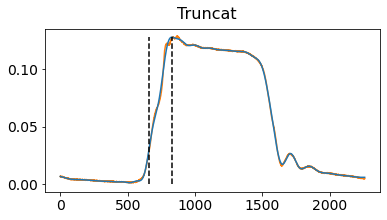


MLSi20HV7kV10mL2Hz - Trial16 - Seg6
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.129 (bar) in 0.084 (sec)

(2252,)
0.14099502391997243
0.13370196180890345


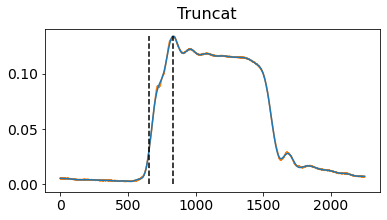


MLSi20HV7kV10mL2Hz - Trial16 - Seg7
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.133 (bar) in 0.088 (sec)

(2253,)
0.14261484618871928
0.13384223691229438


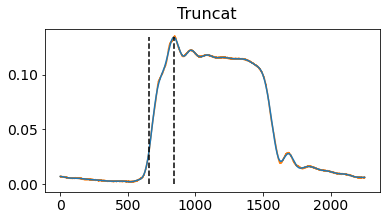


MLSi20HV7kV10mL2Hz - Trial16 - Seg8
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.135 (bar) in 0.090 (sec)

(2264,)
0.16923766763544995
0.15354914525570312


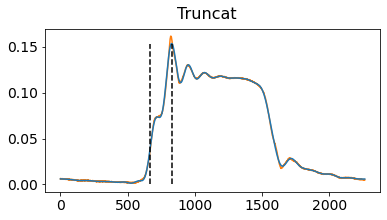


MLSi20HV7kV10mL2Hz - Trial16 - Seg9
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.162 (bar) in 0.081 (sec)

(2252,)
0.14203748379589862
0.13301914929417005


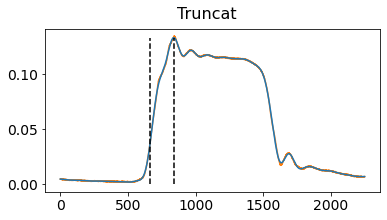


MLSi20HV7kV10mL2Hz - Trial16 - Seg10
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.134 (bar) in 0.090 (sec)

(2221,)
0.14104313745270747
0.1337401891315326


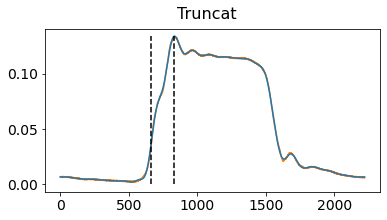


MLSi20HV7kV10mL2Hz - Trial16 - Seg11
Avg. Pressure of zipping = 0.089 (bar), Max. P. = 0.133 (bar) in 0.087 (sec)

(2229,)
0.1405620021253569
0.13149044538106752


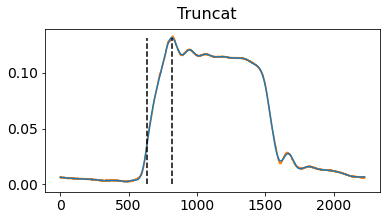


MLSi20HV7kV10mL2Hz - Trial16 - Seg12
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.133 (bar) in 0.092 (sec)

(2260,)
0.1688367215293245
0.15254097723840143


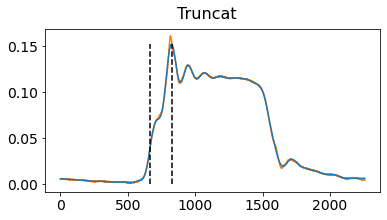


MLSi20HV7kV10mL2Hz - Trial16 - Seg13
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.161 (bar) in 0.081 (sec)

(2255,)
0.14009690464225139
0.13064973779540004


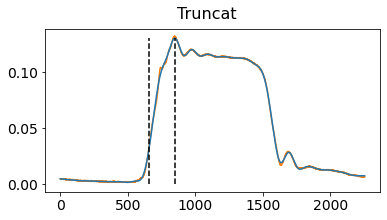


MLSi20HV7kV10mL2Hz - Trial16 - Seg14
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.132 (bar) in 0.095 (sec)

(2251,)
0.16394517903459385
0.14961945657385584


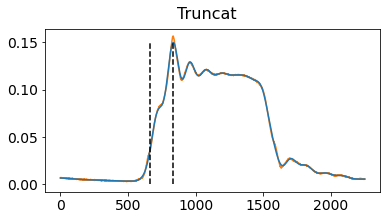


MLSi20HV7kV10mL2Hz - Trial16 - Seg15
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.156 (bar) in 0.086 (sec)

(2249,)
0.13860538512746468
0.1285751376831401


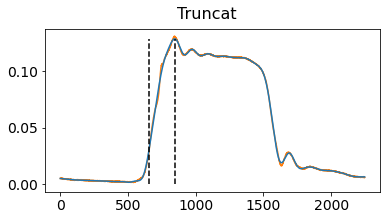


MLSi20HV7kV10mL2Hz - Trial16 - Seg16
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.131 (bar) in 0.093 (sec)

MLSi20HV7kV10mL4Hz
Signal frequency (Hz) = 4.000
(20500,)
max value of raw data = 0.188
0.16664044895718405
[ 2826  3957  5088  6221  7353  8485  9613 10741 11870 12996 14119 15248
 16375 17508 18633 19761]
[ 3505  4635  5765  6896  8027  9159 10285 11416 12542 13664 14791 15918
 17046 18176 19300 20431]
Avg. segment length = 1128
(1129,)
0.18800194540212156
0.1666395962290788


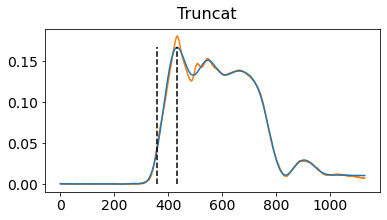


MLSi20HV7kV10mL4Hz - Trial17 - Seg1
Avg. Pressure of zipping = 0.117 (bar), Max. P. = 0.180 (bar) in 0.036 (sec)

(1131,)
0.16829143482499387
0.15379260441337142


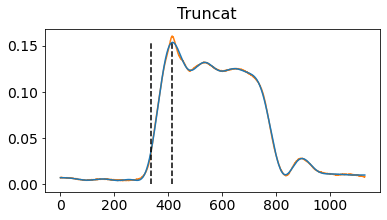


MLSi20HV7kV10mL4Hz - Trial17 - Seg2
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.161 (bar) in 0.039 (sec)

(1130,)
0.16169988084029127
0.14890051123455128


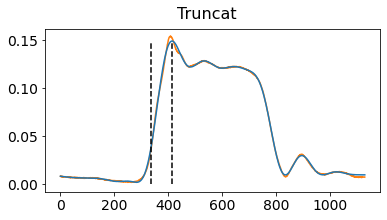


MLSi20HV7kV10mL4Hz - Trial17 - Seg3
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.154 (bar) in 0.039 (sec)

(1132,)
0.16917351625846988
0.1558781830191651


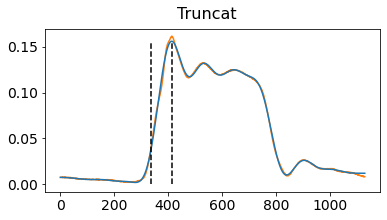


MLSi20HV7kV10mL4Hz - Trial17 - Seg4
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.161 (bar) in 0.038 (sec)

(1132,)
0.15568568924840934
0.14186417059819265


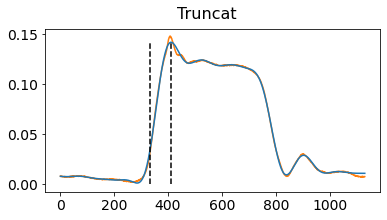


MLSi20HV7kV10mL4Hz - Trial17 - Seg5
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.148 (bar) in 0.038 (sec)

(1132,)
0.15159603896592963
0.14157483905812726


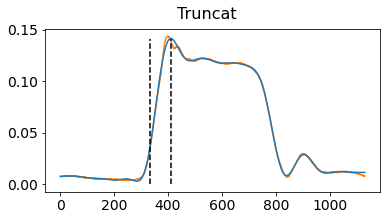


MLSi20HV7kV10mL4Hz - Trial17 - Seg6
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.144 (bar) in 0.039 (sec)

(1127,)
0.15032904927057317
0.13775156092720364


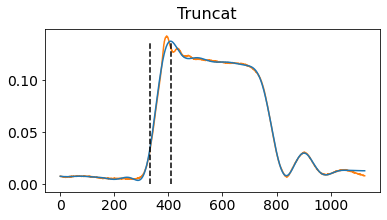


MLSi20HV7kV10mL4Hz - Trial17 - Seg7
Avg. Pressure of zipping = 0.099 (bar), Max. P. = 0.143 (bar) in 0.038 (sec)

(1129,)
0.1398563369785761
0.13278218756396268


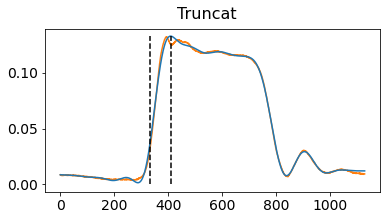


MLSi20HV7kV10mL4Hz - Trial17 - Seg8
Avg. Pressure of zipping = 0.098 (bar), Max. P. = 0.132 (bar) in 0.039 (sec)

(1128,)
0.14229408930381893
0.13265585949440445


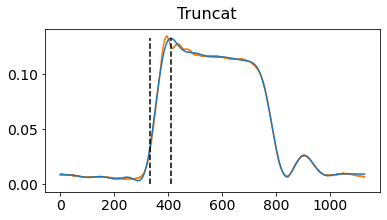


MLSi20HV7kV10mL4Hz - Trial17 - Seg9
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.135 (bar) in 0.038 (sec)

(1124,)
0.1496714976565274
0.14167939605713545


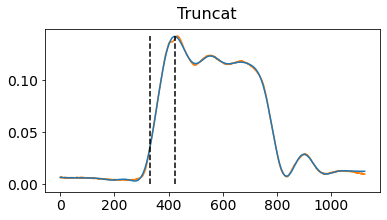


MLSi20HV7kV10mL4Hz - Trial17 - Seg10
Avg. Pressure of zipping = 0.100 (bar), Max. P. = 0.142 (bar) in 0.045 (sec)

(1125,)
0.14035351015017167
0.13304059809487226


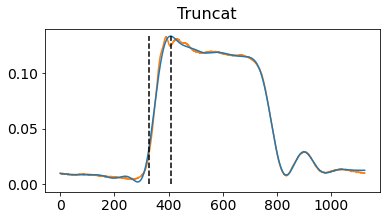


MLSi20HV7kV10mL4Hz - Trial17 - Seg11
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.133 (bar) in 0.039 (sec)

(1128,)
0.13935916380698055
0.12976336882242737


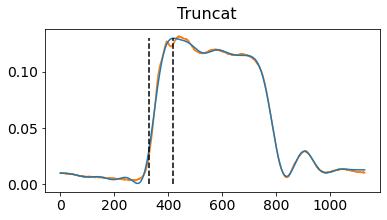


MLSi20HV7kV10mL4Hz - Trial17 - Seg12
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.132 (bar) in 0.044 (sec)

(1127,)
0.13783556860370377
0.13065814754618374


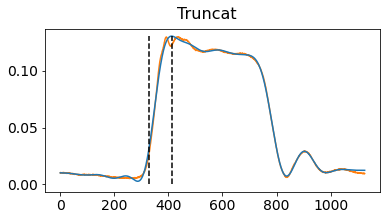


MLSi20HV7kV10mL4Hz - Trial17 - Seg13
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.130 (bar) in 0.042 (sec)

(1132,)
0.14069030487931708
0.13074225596415945


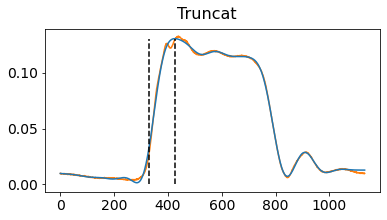


MLSi20HV7kV10mL4Hz - Trial17 - Seg14
Avg. Pressure of zipping = 0.098 (bar), Max. P. = 0.133 (bar) in 0.048 (sec)

(1124,)
0.13692141148173773
0.12789887985742734


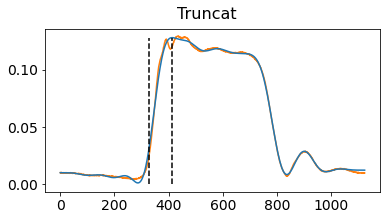


MLSi20HV7kV10mL4Hz - Trial17 - Seg15
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.129 (bar) in 0.043 (sec)

(1130,)
0.13850915806199457
0.12876674689917797


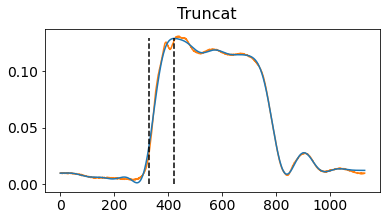


MLSi20HV7kV10mL4Hz - Trial17 - Seg16
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.131 (bar) in 0.048 (sec)

MLSi20HV7kV10mL10Hz
Signal frequency (Hz) = 10.000
(8200,)
max value of raw data = 0.199
0.18595847240965774
[2378 2814 3265 3718 4171 4625 5074 5528 5979 6433 6888 7340 7793]
[2634 3085 3537 3988 4438 4886 5338 5791 6245 6701 7154 7604 8059]
Avg. segment length = 451
(452,)
0.19866711182505886
0.18559751239203087


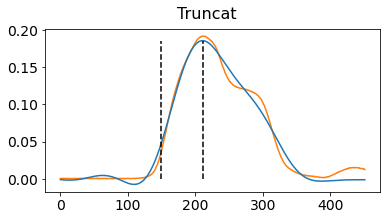


MLSi20HV7kV10mL10Hz - Trial18 - Seg1
Avg. Pressure of zipping = 0.134 (bar), Max. P. = 0.192 (bar) in 0.031 (sec)

(443,)
0.17690375718456877
0.16615942589340996


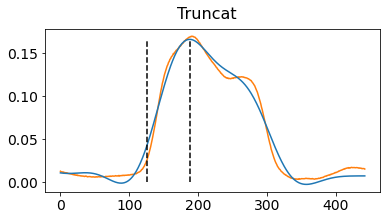


MLSi20HV7kV10mL10Hz - Trial18 - Seg2
Avg. Pressure of zipping = 0.120 (bar), Max. P. = 0.170 (bar) in 0.031 (sec)

(452,)
0.17578110808741748
0.1622925928157357


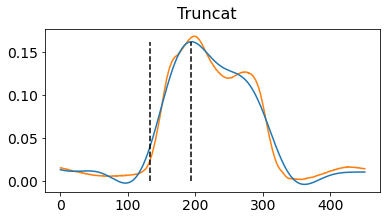


MLSi20HV7kV10mL10Hz - Trial18 - Seg3
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.169 (bar) in 0.030 (sec)

(452,)
0.17642262185721824
0.16111718384463217


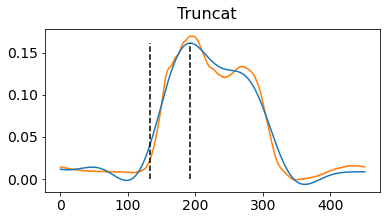


MLSi20HV7kV10mL10Hz - Trial18 - Seg4
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.169 (bar) in 0.029 (sec)

(451,)
0.17393675599924036
0.15624017523022815


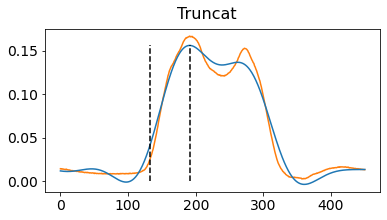


MLSi20HV7kV10mL10Hz - Trial18 - Seg5
Avg. Pressure of zipping = 0.112 (bar), Max. P. = 0.167 (bar) in 0.029 (sec)

(451,)
0.1876972263614662
0.17363424891231988


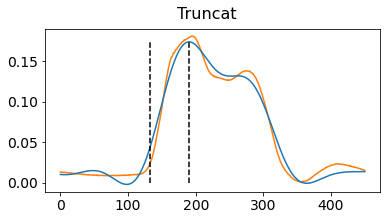


MLSi20HV7kV10mL10Hz - Trial18 - Seg6
Avg. Pressure of zipping = 0.124 (bar), Max. P. = 0.181 (bar) in 0.029 (sec)

(451,)
0.1841207870948271
0.16350260195116298


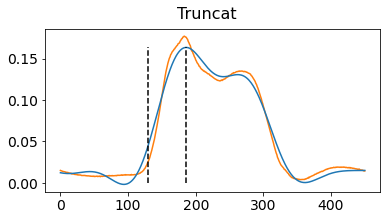


MLSi20HV7kV10mL10Hz - Trial18 - Seg7
Avg. Pressure of zipping = 0.119 (bar), Max. P. = 0.177 (bar) in 0.029 (sec)

(453,)
0.17983868268140715
0.16183089652982713


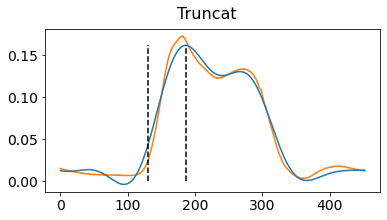


MLSi20HV7kV10mL10Hz - Trial18 - Seg8
Avg. Pressure of zipping = 0.119 (bar), Max. P. = 0.173 (bar) in 0.028 (sec)

(453,)
0.17521978353884185
0.1568333113457463


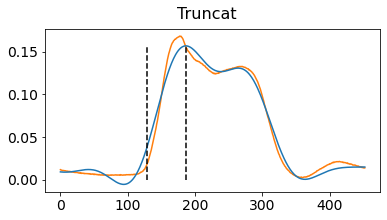


MLSi20HV7kV10mL10Hz - Trial18 - Seg9
Avg. Pressure of zipping = 0.115 (bar), Max. P. = 0.168 (bar) in 0.029 (sec)

(455,)
0.1763103569475031
0.1572181359317266


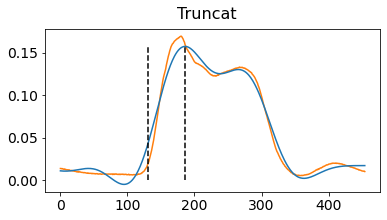


MLSi20HV7kV10mL10Hz - Trial18 - Seg10
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.169 (bar) in 0.028 (sec)

(454,)
0.1671206721951075
0.1527288310873523


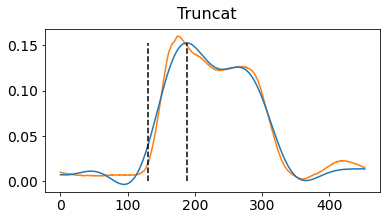


MLSi20HV7kV10mL10Hz - Trial18 - Seg11
Avg. Pressure of zipping = 0.112 (bar), Max. P. = 0.160 (bar) in 0.029 (sec)

(451,)
0.17141881445277246
0.15519039196503767


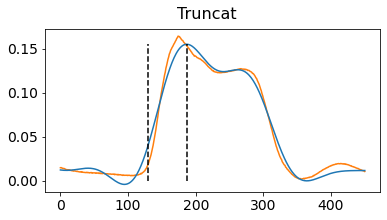


MLSi20HV7kV10mL10Hz - Trial18 - Seg12
Avg. Pressure of zipping = 0.115 (bar), Max. P. = 0.164 (bar) in 0.029 (sec)

(454,)
0.17592544868562265
0.1520816008629489


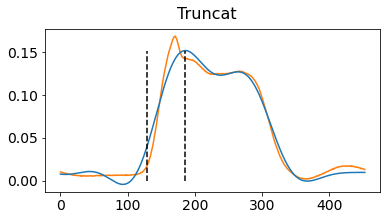


MLSi20HV7kV10mL10Hz - Trial18 - Seg13
Avg. Pressure of zipping = 0.112 (bar), Max. P. = 0.169 (bar) in 0.029 (sec)

MLSi20HV7kV10mL20Hz
Signal frequency (Hz) = 20.000
(4100,)
max value of raw data = 0.204
0.17962349429732835
[2195 2408 2627 2833 3055 3272 3505 3726]
[2323 2540 2743 2967 3190 3414 3634 3858]
Avg. segment length = 219
(219,)
0.20441836274700548
0.1591784808342966


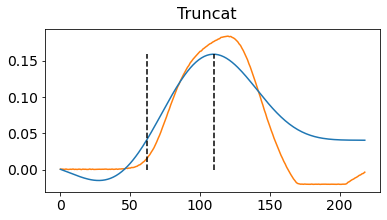


MLSi20HV7kV10mL20Hz - Trial19 - Seg1
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.184 (bar) in 0.024 (sec)

(215,)
0.20369665975597964
0.14879912149256197


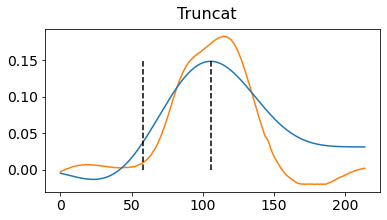


MLSi20HV7kV10mL20Hz - Trial19 - Seg2
Avg. Pressure of zipping = 0.100 (bar), Max. P. = 0.183 (bar) in 0.024 (sec)

(211,)
0.19534094290432502
0.1420874139674988


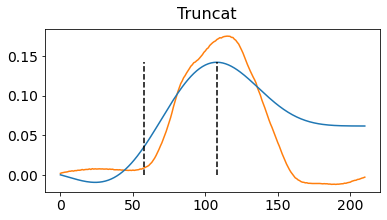


MLSi20HV7kV10mL20Hz - Trial19 - Seg3
Avg. Pressure of zipping = 0.098 (bar), Max. P. = 0.175 (bar) in 0.025 (sec)

(215,)
0.19901360923643424
0.15315821408356817


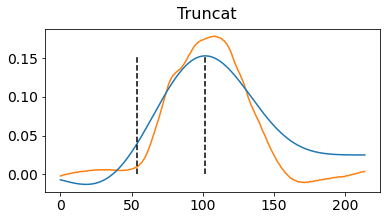


MLSi20HV7kV10mL20Hz - Trial19 - Seg4
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.179 (bar) in 0.024 (sec)

(222,)
0.19694472732882687
0.1539433266763298


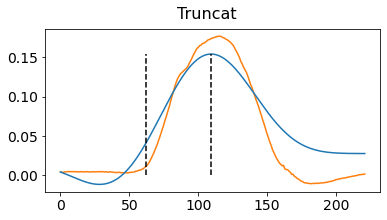


MLSi20HV7kV10mL20Hz - Trial19 - Seg5
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.177 (bar) in 0.024 (sec)

(221,)
0.20355231915777447
0.1451093421123289


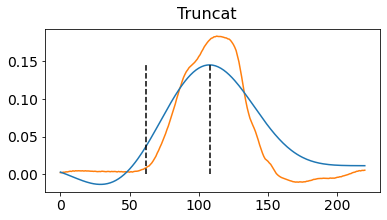


MLSi20HV7kV10mL20Hz - Trial19 - Seg6
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.183 (bar) in 0.023 (sec)

(226,)
0.19971927438321507
0.1634422498022937


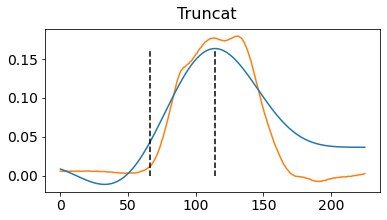


MLSi20HV7kV10mL20Hz - Trial19 - Seg7
Avg. Pressure of zipping = 0.113 (bar), Max. P. = 0.179 (bar) in 0.024 (sec)

(223,)
0.19325602315247262
0.1561524535218233


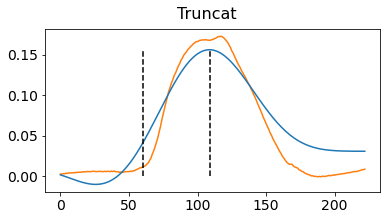


MLSi20HV7kV10mL20Hz - Trial19 - Seg8
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.173 (bar) in 0.025 (sec)



In [5]:
'''Measurement 2022 Frequency comparison'''
pressData = []
Fs = 2000

'''
Shifted0.5s: 1-3, 5-7, 9-11, ...
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77]
'''

for root, directories, files in walk(".\Data220401Relabelled\Act6Freq"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum, sigFreq = decodeFileName2(fileName)
                
                trialArray = np.arange(1, 40, 2.22)/sigFreq
                beginInd = (Fs * np.array(0.1 + trialArray)).astype(int)
                endInd = (Fs * np.array(0.1 + 2/sigFreq + trialArray)).astype(int)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])
                
                cutInd = cutRepeatTrial(data, Fs, inactivePressure, 20, 8)           
                
                for i in range(len(cutInd)-1): 
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[cutInd[i]:cutInd[i+1]], Fs, 
                                                                               inactivePressure, 20, 8)
                    P0 = data[beginInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd, sigFreq]) # 1 bar = 100 kPa
                    
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex', 'SigFreq'])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv")

In [ ]:
'''Measurement 2021'''
Fs = 1000

pressData = []
''' Process measurement data saved as individual csv files by trial '''
for root, directories, files in walk(".\data\ValidData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data, Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             data[:segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data switch three times with reversed polarity from bipolar HV Trek box '''
beginInd = ((np.array([1, 8, 15]) - 0.1) * Fs).astype(int)
endInd = ((np.array([5, 12, 19]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data driven by reversed polarity from bipolar wearable controller '''                
for root, directories, files in walk(".\data\ValidData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)
            names = re.split('U6900V', names)[0] # Shorten the names

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')     
            
            data = (data[:,1] - calib[1]) * calib[0] # Unit conversion and only keep used channel (1)
            
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data[:int(3.5*Fs)], Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             data[:segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa

''' Process data switch two times with reversed polarity from bipolar HV Trek box (2022) '''
beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2) 
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]*100, segInd]) # 1 bar = 100 kPa
                
                
            
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex'])

for aCondi in condiTable['CondiName']: # Drop any extra measurement more than five trials
    allTrials = pressData[pressData['CondiName'] == aCondi]
    trialNum = allTrials.shape[0]
    if trialNum > 5:
        pressData = pressData.drop(pressData[pressData['CondiName'] == aCondi].index)
        pressData = pressData.append(allTrials.iloc[:5])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
# pressData.to_csv("Measurements.csv")



In [ ]:
# ax,_=aPlot()

# for i in range(5):
#     ax.plot(sigData.loc[sigData['CondiName'] == 'Mylar16NoShift','PressSig_kPa'].iloc[i])

In [14]:
sigData.head()

CondiName                                       PressSig_kPa  \
0  MLSi20HV7kV1Hz  [0.36790014941242377, 0.3502585207429034, 0.40...   
1  MLSi20HV7kV1Hz  [0.9179982070165577, 0.8378089857914651, 0.882...   
2  MLSi20HV7kV1Hz  [0.629317010606225, 0.5763921245976639, 0.6373...   
3  MLSi20HV7kV1Hz  [0.8490354767629781, 0.8329976325179597, 0.829...   
4  MLSi20HV7kV1Hz  [0.640543501577738, 0.6196943040592138, 0.6116...   

       SegIndex  
0  [1236, 1537]  
1  [1181, 1481]  
2  [1177, 1528]  
3  [1208, 1515]  
4  [1270, 1594]

In [15]:
simData = pd.read_csv("./data./temp_result.csv") # Data from model simulation
simData.tail()

CondiName      PFull_Pa    P1Expan_Pa    P2Expan_Pa  \
26   L0WsSi6-16Trek9kVHVTop  26660.655160  26752.465236  26823.201681   
27  L0WsSi6-16Trek10kVHVTop  32914.389087  33027.734859  33115.063804   
28  L0WsSi5-20sTrek9kVHVBot  23018.571641  23076.868762  23076.868762   
29          MLSi20HV7kV.5Hz  19818.711502  19818.711502  19740.115144   
30           MLSi20HV7kV1Hz  19818.711502  19818.711502  19740.115144   

       P1Cell_Pa  EsFull_J  Es1Expan_J  Es2Expan_J  Es1Cell_J  dVFull_m3  \
26  28021.234350  0.319638    0.245677    0.173914   0.010129   0.000006   
27  34594.116481  0.394614    0.303305    0.214708   0.012505   0.000006   
28  24208.791110  0.276067    0.205426    0.136951   0.011963   0.000006   
29  21471.036681  0.237756    0.184921    0.133962   0.010396   0.000006   
30  21471.036681  0.237756    0.184921    0.133962   0.010396   0.000006   

    dV1Expan_m3  dV2Expan_m3    dV1Cell_m3    lossFactor  
26     0.000005     0.000003  1.807397e-07  1.098169e+08  
27     0.000005     0.000003  1.807397e-07  1.098169e+08  
28     0.000004     0.000003  2.470741e-07  1.098169e+08  
29     0.000005     0.000003  2.421022e-07  1.098169e+08  
30     0.000005     0.000003  2.421022e-07  1.098169e+08

Initial Volume (mL) = 6.271459
Initial Pressure (kPa) = 3.079266
[1236 1537]
MLSi20HV7kV1Hz inital air volume = 6.271459 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.99 kPa


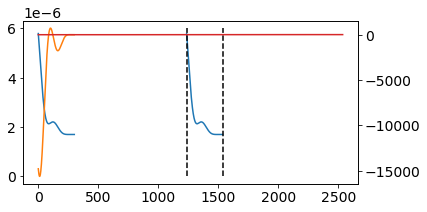

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.225190
Initial Pressure (kPa) = 2.803415
[1181 1481]
MLSi20HV7kV1Hz inital air volume = 6.225190 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.90 kPa


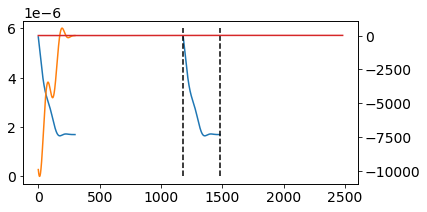

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.172618
Initial Pressure (kPa) = 2.983039
[1177 1528]
MLSi20HV7kV1Hz inital air volume = 6.172618 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.29 kPa


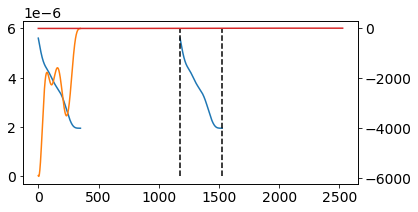

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.152389
Initial Pressure (kPa) = 2.500300
[1208 1515]
MLSi20HV7kV1Hz inital air volume = 6.152389 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.68 kPa


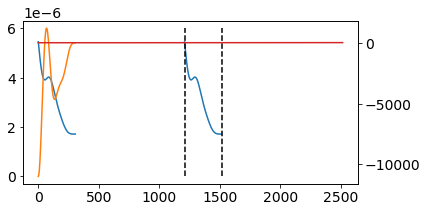

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.189383
Initial Pressure (kPa) = 2.388035
[1270 1594]
MLSi20HV7kV1Hz inital air volume = 6.189383 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.60 kPa


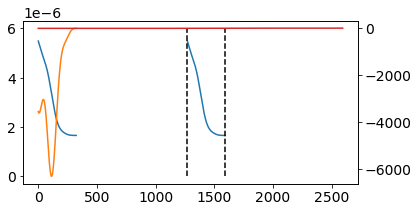

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.108288
Initial Pressure (kPa) = 2.902850
[1303 1578]
MLSi20HV7kV1Hz inital air volume = 6.108288 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.84 kPa


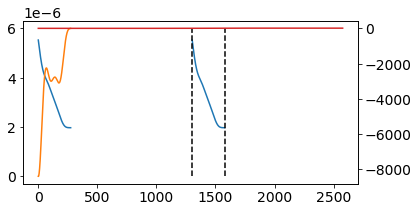

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.251872
Initial Pressure (kPa) = 2.697565
[1267 1898]
MLSi20HV7kV1Hz inital air volume = 6.251872 mL
MLSi20HV7kV1Hz avg. pressure loss = -1.41 kPa


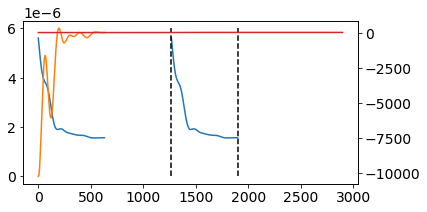

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.137931
Initial Pressure (kPa) = 2.671905
[1262 1612]
MLSi20HV7kV1Hz inital air volume = 6.137931 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.36 kPa


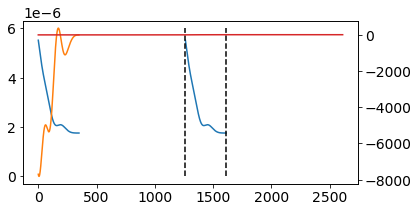

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.184287
Initial Pressure (kPa) = 2.606150
[1297 1620]
MLSi20HV7kV1Hz inital air volume = 6.184287 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.63 kPa


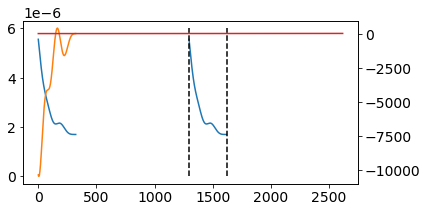

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.247332
Initial Pressure (kPa) = 2.609357
[1336 1665]
MLSi20HV7kV1Hz inital air volume = 6.247332 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.66 kPa


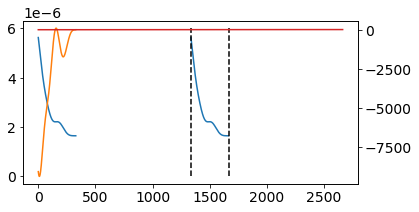

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.263923
Initial Pressure (kPa) = 2.652659
[1377 1731]
MLSi20HV7kV1Hz inital air volume = 6.263923 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.51 kPa


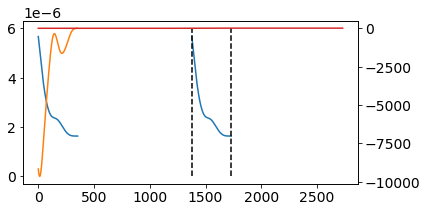

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.293701
Initial Pressure (kPa) = 2.649452
[1411 1761]
MLSi20HV7kV1Hz inital air volume = 6.293701 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.51 kPa


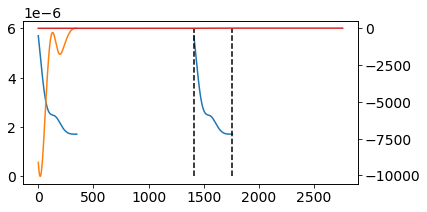

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.280618
Initial Pressure (kPa) = 2.654263
[1448 1794]
MLSi20HV7kV1Hz inital air volume = 6.280618 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.52 kPa


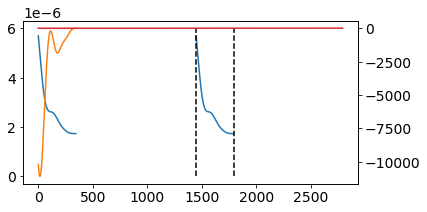

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.382682
Initial Pressure (kPa) = 2.710396
[1491 1831]
MLSi20HV7kV1Hz inital air volume = 6.382682 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.56 kPa


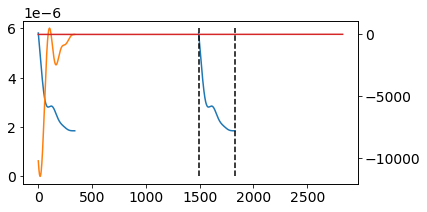

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.313457
Initial Pressure (kPa) = 2.708792
[1528 2691]
MLSi20HV7kV1Hz inital air volume = 6.313457 mL
MLSi20HV7kV1Hz avg. pressure loss = -0.78 kPa


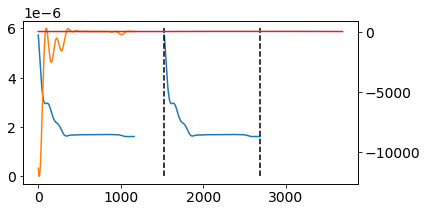

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.203973
Initial Pressure (kPa) = 2.748887
[1577 1994]
MLSi20HV7kV1Hz inital air volume = 6.203973 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.09 kPa


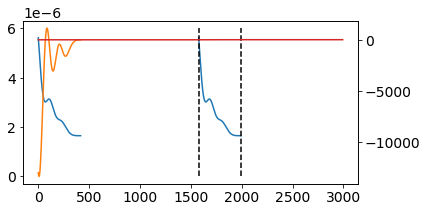

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.139084
Initial Pressure (kPa) = 2.731245
[1603 1969]
MLSi20HV7kV1Hz inital air volume = 6.139084 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.29 kPa


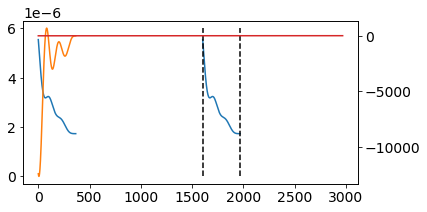

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.119101
Initial Pressure (kPa) = 2.607753
[1640 2001]
MLSi20HV7kV1Hz inital air volume = 6.119101 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.26 kPa


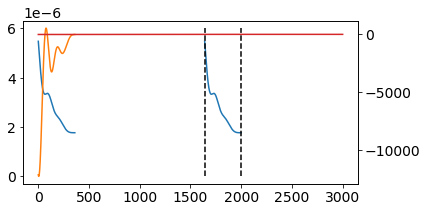

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.268944
Initial Pressure (kPa) = 2.880397
[1193 1509]
MLSi20HV7kV1Hz inital air volume = 6.268944 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.82 kPa


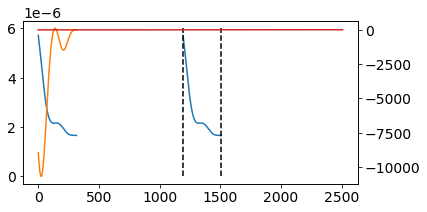

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.260217
Initial Pressure (kPa) = 2.721622
[1225 1563]
MLSi20HV7kV1Hz inital air volume = 6.260217 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.59 kPa


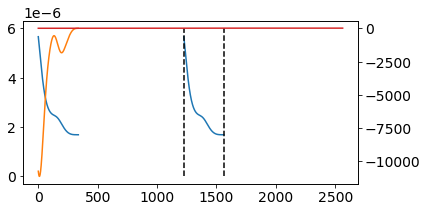

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.289788
Initial Pressure (kPa) = 2.792189
[1305 2508]
MLSi20HV7kV1Hz inital air volume = 6.289788 mL
MLSi20HV7kV1Hz avg. pressure loss = -0.75 kPa


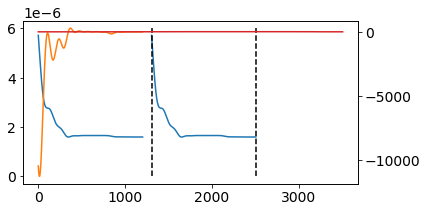

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.262422
Initial Pressure (kPa) = 2.968605
[1380 1752]
MLSi20HV7kV1Hz inital air volume = 6.262422 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.36 kPa


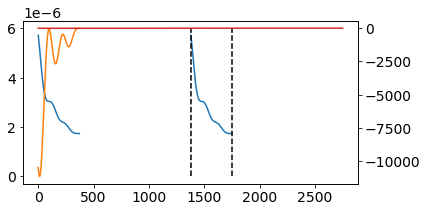

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.173382
Initial Pressure (kPa) = 2.878793
[1456 1814]
MLSi20HV7kV1Hz inital air volume = 6.173382 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.36 kPa


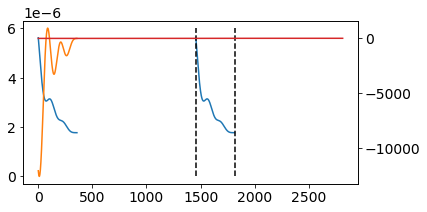

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.184514
Initial Pressure (kPa) = 2.736056
[1519 1858]
MLSi20HV7kV1Hz inital air volume = 6.184514 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.44 kPa


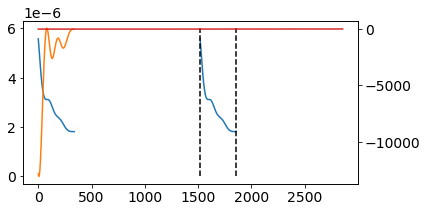

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.089655
Initial Pressure (kPa) = 2.521149
[1542 1872]
MLSi20HV7kV1Hz inital air volume = 6.089655 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.51 kPa


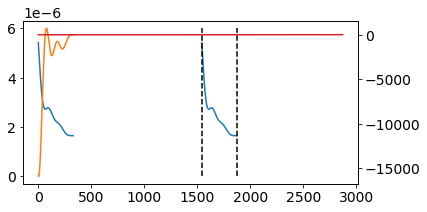

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.162674
Initial Pressure (kPa) = 2.591716
[1602 1940]
MLSi20HV7kV1Hz inital air volume = 6.162674 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.45 kPa


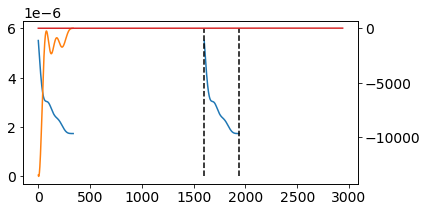

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.189580
Initial Pressure (kPa) = 2.588508
[1681 2016]
MLSi20HV7kV1Hz inital air volume = 6.189580 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.47 kPa


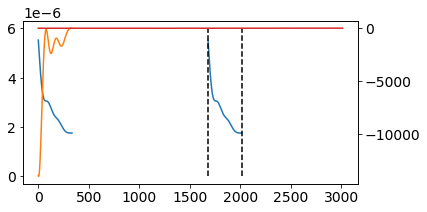

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.216591
Initial Pressure (kPa) = 2.591716
[1746 2080]
MLSi20HV7kV1Hz inital air volume = 6.216591 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.47 kPa


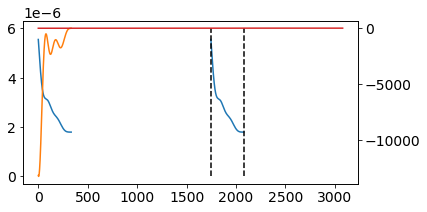

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.181896
Initial Pressure (kPa) = 2.482658
[1816 2150]
MLSi20HV7kV1Hz inital air volume = 6.181896 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.48 kPa


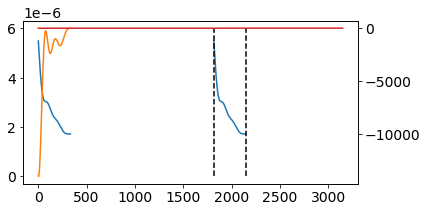

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.218732
Initial Pressure (kPa) = 2.444167
[1886 2209]
MLSi20HV7kV1Hz inital air volume = 6.218732 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.57 kPa


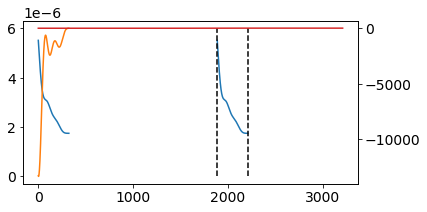

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.077651
Initial Pressure (kPa) = 2.295016
[1948 2304]
MLSi20HV7kV1Hz inital air volume = 6.077651 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.38 kPa


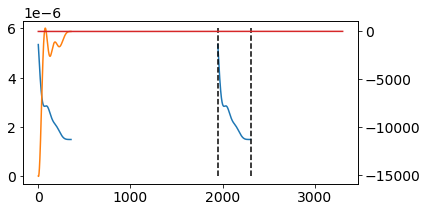

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.128286
Initial Pressure (kPa) = 2.410488
[1948 2303]
MLSi20HV7kV1Hz inital air volume = 6.128286 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.32 kPa


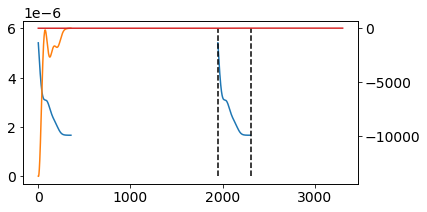

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.103119
Initial Pressure (kPa) = 2.378412
[2022 2381]
MLSi20HV7kV1Hz inital air volume = 6.103119 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.27 kPa


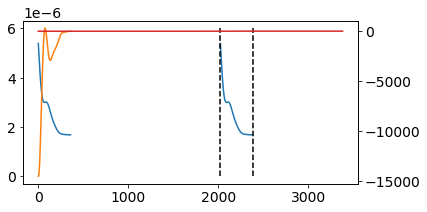

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.091079
Initial Pressure (kPa) = 2.368790
[2089 2446]
MLSi20HV7kV1Hz inital air volume = 6.091079 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.28 kPa


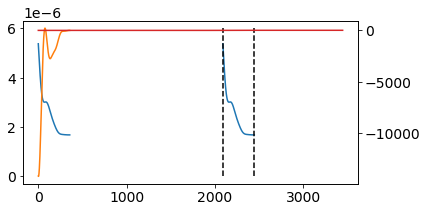

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.107332
Initial Pressure (kPa) = 2.371997
[2115 2472]
MLSi20HV7kV1Hz inital air volume = 6.107332 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.28 kPa


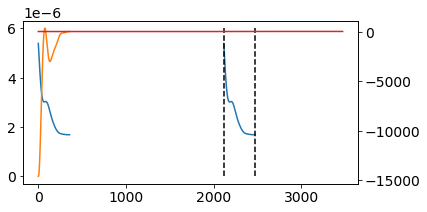

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.204242
Initial Pressure (kPa) = 2.439356
[2186 2547]
MLSi20HV7kV1Hz inital air volume = 6.204242 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.27 kPa


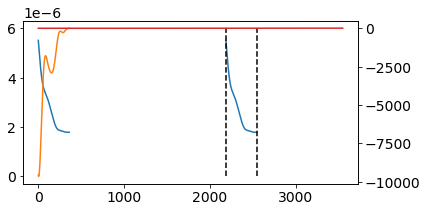

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.259430
Initial Pressure (kPa) = 2.797000
[ 595 1134]
MLSi20HV7kV.5Hz inital air volume = 6.259430 mL
MLSi20HV7kV.5Hz avg. pressure loss = -1.48 kPa


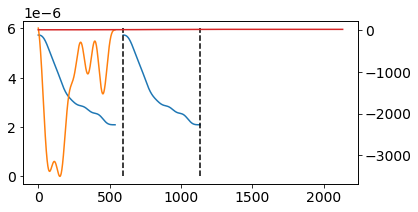

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.048907
Initial Pressure (kPa) = 2.466620
[ 730 1269]
MLSi20HV7kV.5Hz inital air volume = 6.048907 mL
MLSi20HV7kV.5Hz avg. pressure loss = -1.43 kPa


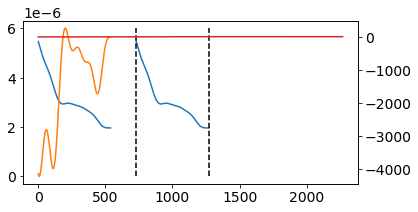

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.043939
Initial Pressure (kPa) = 2.234072
[ 778 1347]
MLSi20HV7kV.5Hz inital air volume = 6.043939 mL
MLSi20HV7kV.5Hz avg. pressure loss = -1.42 kPa


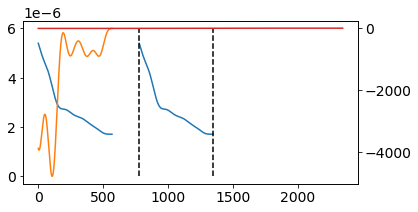

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.118273
Initial Pressure (kPa) = 2.083316
[ 903 1397]
MLSi20HV7kV.5Hz inital air volume = 6.118273 mL
MLSi20HV7kV.5Hz avg. pressure loss = -1.63 kPa


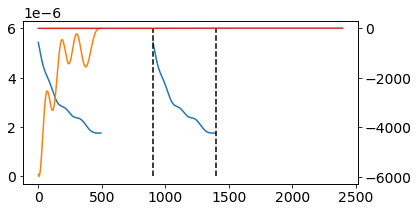

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.030001
Initial Pressure (kPa) = 1.773786
[1034 1452]
MLSi20HV7kV.5Hz inital air volume = 6.030001 mL
MLSi20HV7kV.5Hz avg. pressure loss = -1.73 kPa


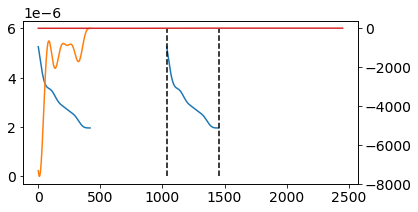

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.182828
Initial Pressure (kPa) = 1.574916
[1173 1562]
MLSi20HV7kV.5Hz inital air volume = 6.182828 mL
MLSi20HV7kV.5Hz avg. pressure loss = -1.84 kPa


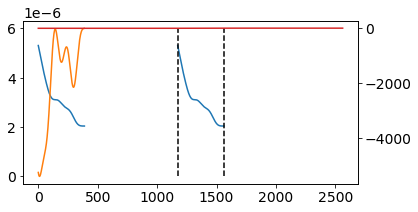

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.124741
Initial Pressure (kPa) = 1.263782
[1274 1555]
MLSi20HV7kV.5Hz inital air volume = 6.124741 mL
MLSi20HV7kV.5Hz avg. pressure loss = -2.39 kPa


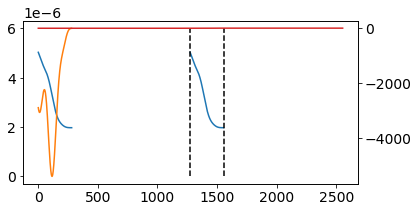

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.165122
Initial Pressure (kPa) = 1.116234
[1429 1598]
MLSi20HV7kV.5Hz inital air volume = 6.165122 mL
MLSi20HV7kV.5Hz avg. pressure loss = -3.62 kPa


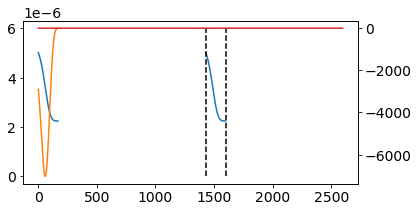

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.952092
Initial Pressure (kPa) = 1.398500
[   0 2314]
MLSi20HV7kV.5Hz inital air volume = 6.952092 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.34 kPa


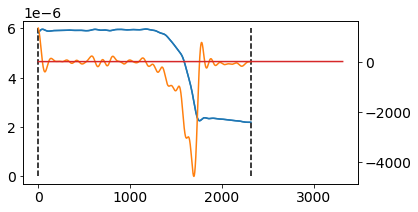

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.834177
Initial Pressure (kPa) = 1.369632
[   0 2545]
MLSi20HV7kV.5Hz inital air volume = 6.834177 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.31 kPa


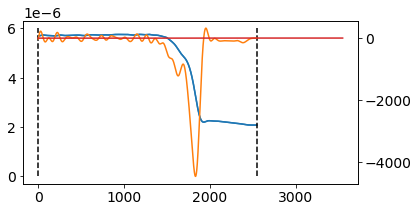

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.840612
Initial Pressure (kPa) = 1.374443
[   0 2774]
MLSi20HV7kV.5Hz inital air volume = 6.840612 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.29 kPa


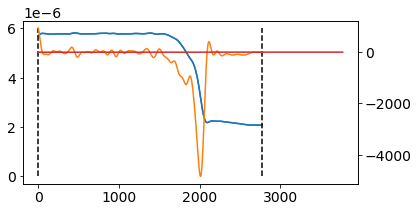

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.667162
Initial Pressure (kPa) = 1.329537
[   0 2956]
MLSi20HV7kV.5Hz inital air volume = 6.667162 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.27 kPa


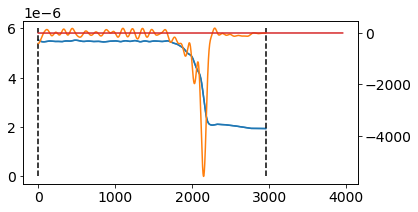

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.701949
Initial Pressure (kPa) = 1.329537
[   0 3115]
MLSi20HV7kV.5Hz inital air volume = 6.701949 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.25 kPa


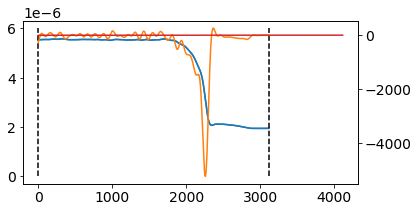

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.574188
Initial Pressure (kPa) = 1.289443
[   0 3183]
MLSi20HV7kV.5Hz inital air volume = 6.574188 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.25 kPa


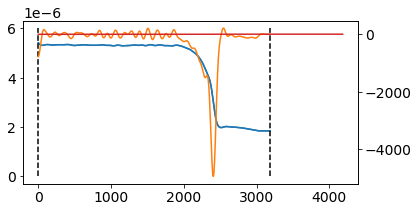

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.536200
Initial Pressure (kPa) = 1.263782
[   0 3334]
MLSi20HV7kV.5Hz inital air volume = 6.536200 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.24 kPa


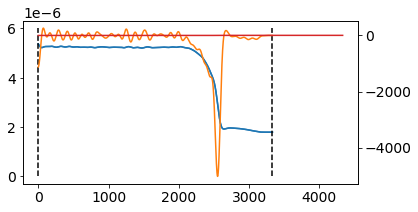

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.631288
Initial Pressure (kPa) = 1.332745
[   0 3341]
MLSi20HV7kV.5Hz inital air volume = 6.631288 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.24 kPa


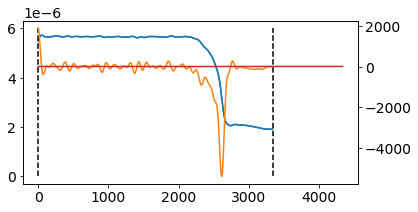

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.493907
Initial Pressure (kPa) = 1.265386
[   0 3557]
MLSi20HV7kV.5Hz inital air volume = 6.493907 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.22 kPa


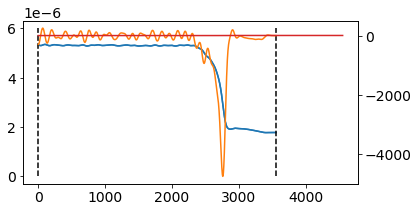

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.462885
Initial Pressure (kPa) = 1.244537
[   0 3611]
MLSi20HV7kV.5Hz inital air volume = 6.462885 mL
MLSi20HV7kV.5Hz avg. pressure loss = -0.22 kPa


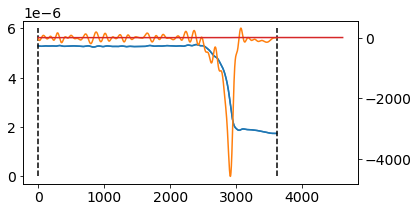

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.144853
Initial Pressure (kPa) = 1.852371
[1230 1530]
MLSi20HV7kV1Hz inital air volume = 6.144853 mL
MLSi20HV7kV1Hz avg. pressure loss = -1.79 kPa


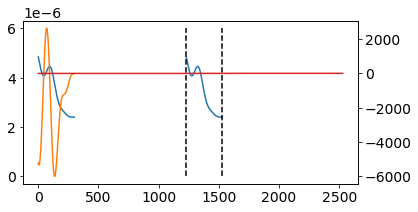

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.200396
Initial Pressure (kPa) = 1.515576
[1274 1529]
MLSi20HV7kV1Hz inital air volume = 6.200396 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.41 kPa


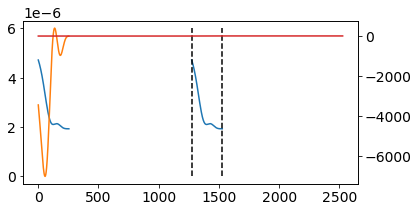

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.195817
Initial Pressure (kPa) = 1.462651
[1286 1536]
MLSi20HV7kV1Hz inital air volume = 6.195817 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.49 kPa


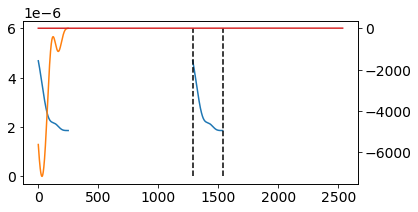

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.224001
Initial Pressure (kPa) = 1.400104
[1319 1551]
MLSi20HV7kV1Hz inital air volume = 6.224001 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.68 kPa


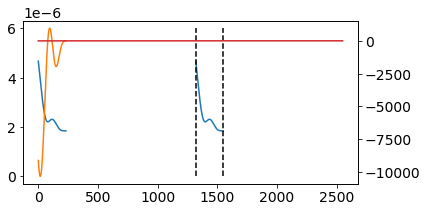

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.325697
Initial Pressure (kPa) = 1.374443
[1275 1564]
MLSi20HV7kV1Hz inital air volume = 6.325697 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.31 kPa


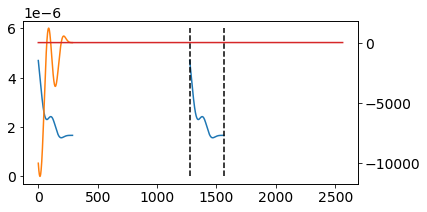

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.222957
Initial Pressure (kPa) = 1.318311
[1291 1575]
MLSi20HV7kV1Hz inital air volume = 6.222957 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.29 kPa


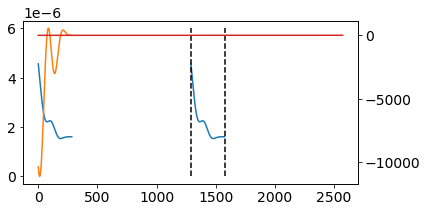

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.205139
Initial Pressure (kPa) = 1.238122
[1297 1592]
MLSi20HV7kV1Hz inital air volume = 6.205139 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.18 kPa


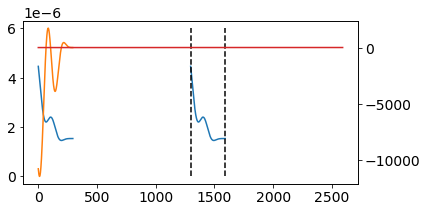

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.199842
Initial Pressure (kPa) = 1.275009
[1340 1623]
MLSi20HV7kV1Hz inital air volume = 6.199842 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.21 kPa


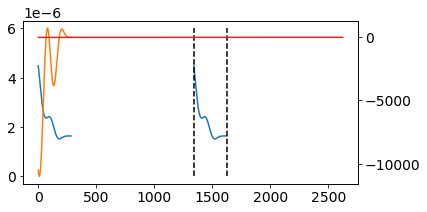

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.124991
Initial Pressure (kPa) = 1.250952
[1365 1666]
MLSi20HV7kV1Hz inital air volume = 6.124991 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.16 kPa


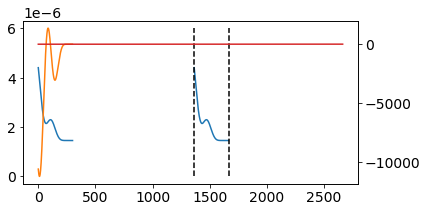

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.160257
Initial Pressure (kPa) = 1.275009
[1401 1730]
MLSi20HV7kV1Hz inital air volume = 6.160257 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.06 kPa


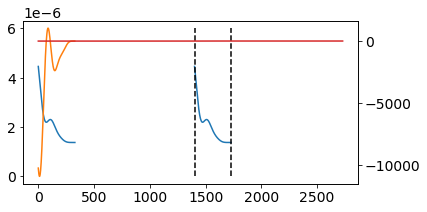

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.086401
Initial Pressure (kPa) = 1.241329
[1432 1752]
MLSi20HV7kV1Hz inital air volume = 6.086401 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.10 kPa


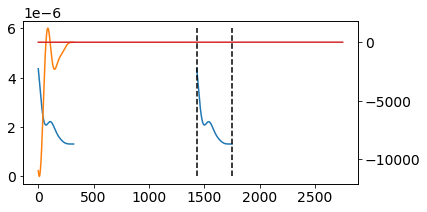

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.113559
Initial Pressure (kPa) = 1.275009
[1466 1769]
MLSi20HV7kV1Hz inital air volume = 6.113559 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.22 kPa


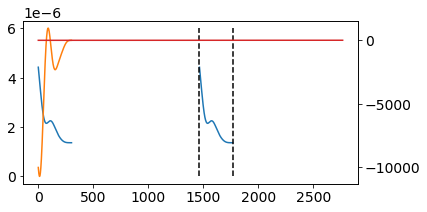

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.178798
Initial Pressure (kPa) = 1.321518
[1505 1799]
MLSi20HV7kV1Hz inital air volume = 6.178798 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.31 kPa


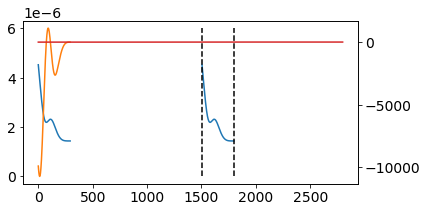

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.229108
Initial Pressure (kPa) = 1.348783
[1541 1831]
MLSi20HV7kV1Hz inital air volume = 6.229108 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.36 kPa


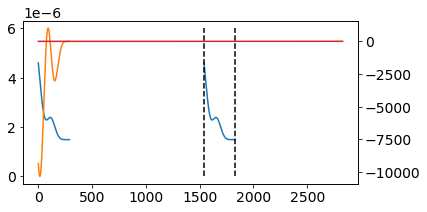

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.302884
Initial Pressure (kPa) = 1.369632
[1549 1842]
MLSi20HV7kV1Hz inital air volume = 6.302884 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.25 kPa


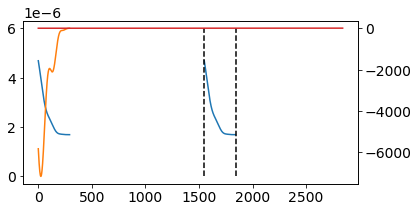

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.228523
Initial Pressure (kPa) = 1.342368
[1536 1849]
MLSi20HV7kV1Hz inital air volume = 6.228523 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.17 kPa


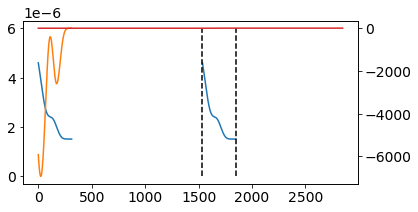

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.239846
Initial Pressure (kPa) = 1.343971
[1585 1891]
MLSi20HV7kV1Hz inital air volume = 6.239846 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.21 kPa


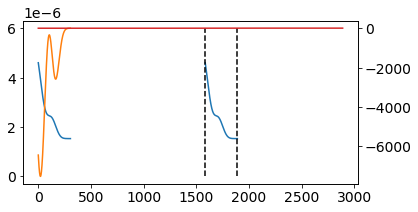

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.050793
Initial Pressure (kPa) = 1.226895
[1643 1973]
MLSi20HV7kV1Hz inital air volume = 6.050793 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.03 kPa


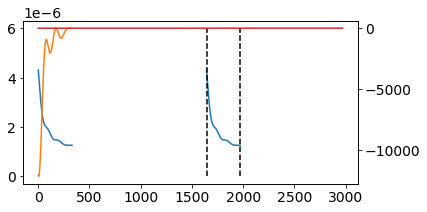

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.093244
Initial Pressure (kPa) = 2.538791
[1199 2290]
MLSi20HV7kV1Hz inital air volume = 6.093244 mL
MLSi20HV7kV1Hz avg. pressure loss = -0.82 kPa


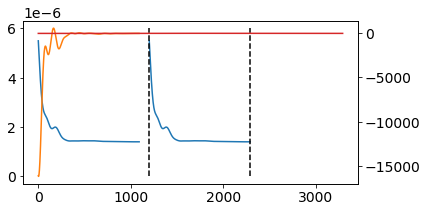

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.203703
Initial Pressure (kPa) = 2.851529
[1278 1762]
MLSi20HV7kV1Hz inital air volume = 6.203703 mL
MLSi20HV7kV1Hz avg. pressure loss = -1.87 kPa


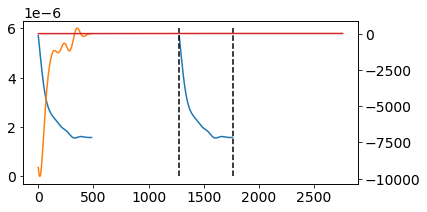

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.206554
Initial Pressure (kPa) = 2.671905
[1329 1641]
MLSi20HV7kV1Hz inital air volume = 6.206554 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.75 kPa


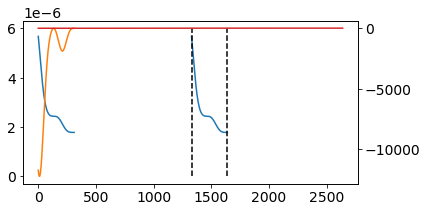

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.238988
Initial Pressure (kPa) = 2.040014
[1375 2827]
MLSi20HV7kV1Hz inital air volume = 6.238988 mL
MLSi20HV7kV1Hz avg. pressure loss = -0.60 kPa


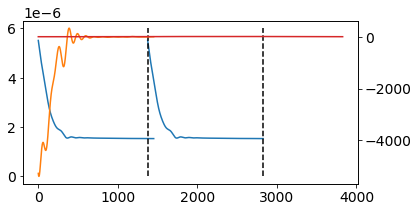

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.253388
Initial Pressure (kPa) = 2.086524
[1472 2903]
MLSi20HV7kV1Hz inital air volume = 6.253388 mL
MLSi20HV7kV1Hz avg. pressure loss = -0.61 kPa


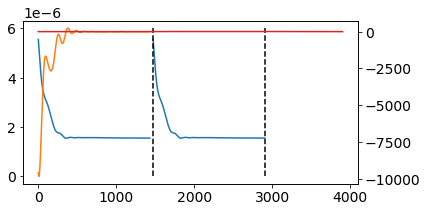

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.147008
Initial Pressure (kPa) = 2.092939
[1556 1883]
MLSi20HV7kV1Hz inital air volume = 6.147008 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.52 kPa


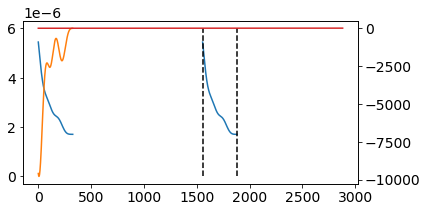

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.126803
Initial Pressure (kPa) = 2.094542
[1617 1962]
MLSi20HV7kV1Hz inital air volume = 6.126803 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.43 kPa


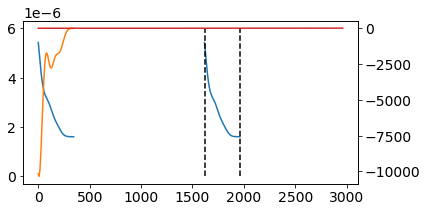

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.135640
Initial Pressure (kPa) = 2.150675
[1558 1904]
MLSi20HV7kV1Hz inital air volume = 6.135640 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.41 kPa


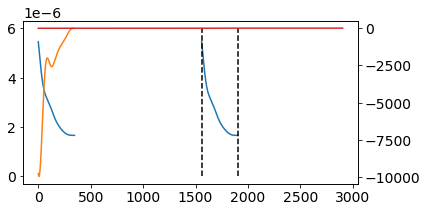

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.191605
Initial Pressure (kPa) = 2.264544
[1643 1984]
MLSi20HV7kV1Hz inital air volume = 6.191605 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.41 kPa


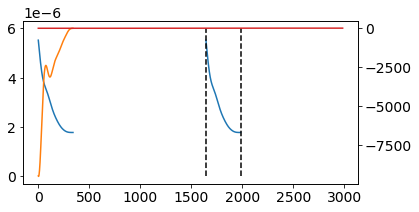

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.244355
Initial Pressure (kPa) = 2.363978
[1724 2061]
MLSi20HV7kV1Hz inital air volume = 6.244355 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.45 kPa


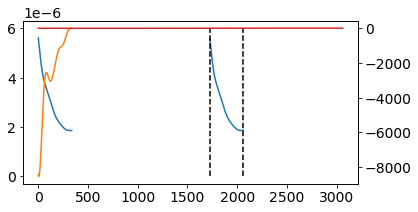

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.243315
Initial Pressure (kPa) = 2.359167
[1792 2122]
MLSi20HV7kV1Hz inital air volume = 6.243315 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.51 kPa


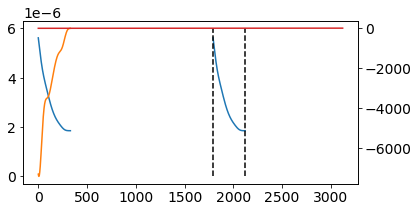

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.274518
Initial Pressure (kPa) = 2.497092
[1864 2188]
MLSi20HV7kV1Hz inital air volume = 6.274518 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.49 kPa


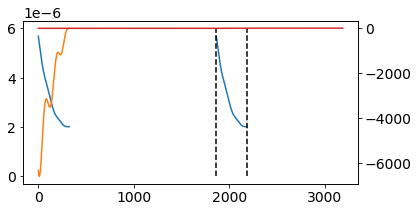

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.265296
Initial Pressure (kPa) = 2.535583
[1934 2260]
MLSi20HV7kV1Hz inital air volume = 6.265296 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.45 kPa


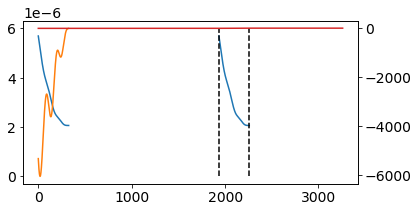

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.204332
Initial Pressure (kPa) = 2.299827
[1974 2321]
MLSi20HV7kV1Hz inital air volume = 6.204332 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.52 kPa


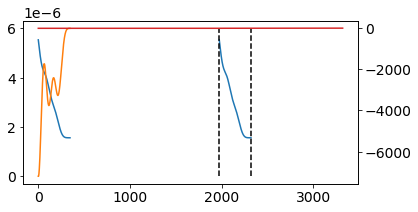

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.197204
Initial Pressure (kPa) = 2.362374
[1977 2290]
MLSi20HV7kV1Hz inital air volume = 6.197204 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.59 kPa


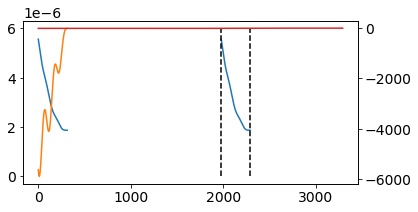

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.202073
Initial Pressure (kPa) = 2.327091
[2044 2371]
MLSi20HV7kV1Hz inital air volume = 6.202073 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.59 kPa


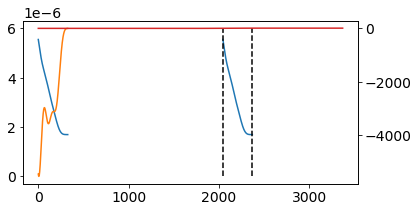

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.203830
Initial Pressure (kPa) = 2.328695
[2070 2389]
MLSi20HV7kV1Hz inital air volume = 6.203830 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.64 kPa


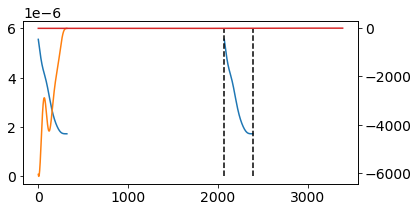

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.233966
Initial Pressure (kPa) = 2.354356
[2157 2483]
MLSi20HV7kV1Hz inital air volume = 6.233966 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.63 kPa


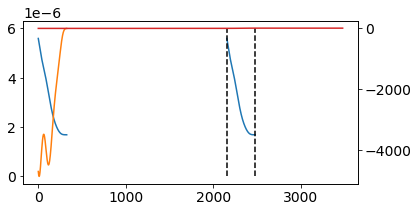

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.099828
Initial Pressure (kPa) = 2.893227
[1208 1589]
MLSi20HV7kV1Hz inital air volume = 6.099828 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.16 kPa


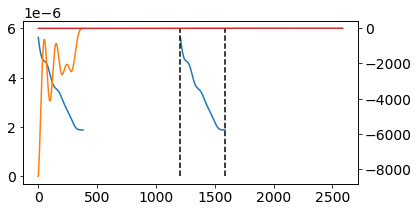

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.100340
Initial Pressure (kPa) = 3.034360
[1257 1465]
MLSi20HV7kV1Hz inital air volume = 6.100340 mL
MLSi20HV7kV1Hz avg. pressure loss = -4.00 kPa


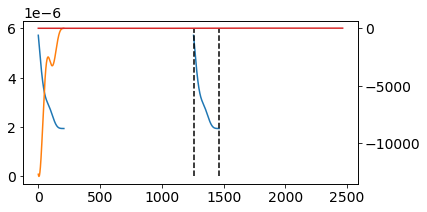

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.289244
Initial Pressure (kPa) = 2.359167
[1056 1408]
MLSi20HV7kV1Hz inital air volume = 6.289244 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.51 kPa


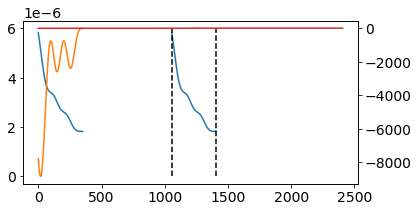

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.222857
Initial Pressure (kPa) = 2.402469
[1120 2541]
MLSi20HV7kV1Hz inital air volume = 6.222857 mL
MLSi20HV7kV1Hz avg. pressure loss = -0.65 kPa


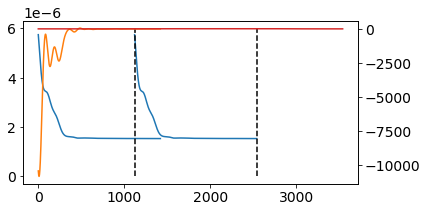

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.216774
Initial Pressure (kPa) = 2.721622
[1206 1784]
MLSi20HV7kV1Hz inital air volume = 6.216774 mL
MLSi20HV7kV1Hz avg. pressure loss = -1.60 kPa


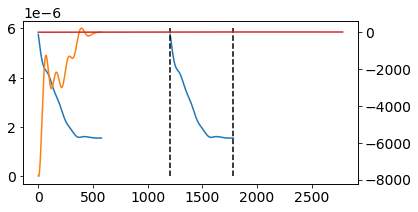

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.142127
Initial Pressure (kPa) = 2.954171
[1198 1494]
MLSi20HV7kV1Hz inital air volume = 6.142127 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.77 kPa


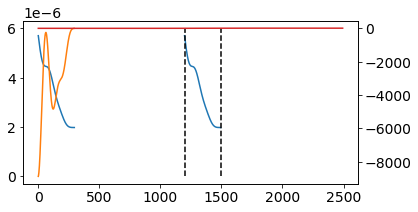

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.177542
Initial Pressure (kPa) = 3.053606
[710 990]
MLSi20HV7kV1Hz inital air volume = 6.177542 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.81 kPa


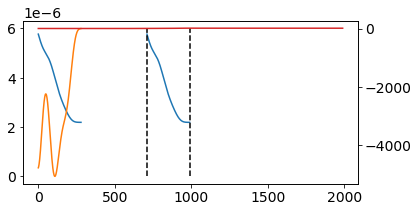

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.141842
Initial Pressure (kPa) = 2.983039
[488 782]
MLSi20HV7kV1Hz inital air volume = 6.141842 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.70 kPa


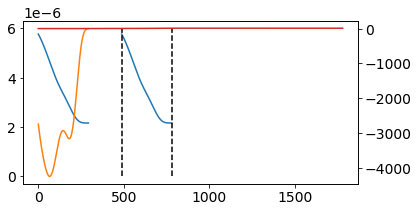

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.165816
Initial Pressure (kPa) = 2.878793
[506 778]
MLSi20HV7kV1Hz inital air volume = 6.165816 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.93 kPa


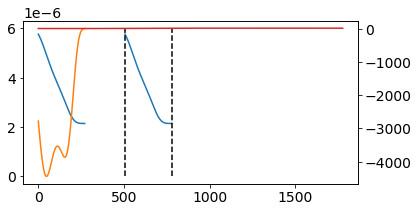

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.167729
Initial Pressure (kPa) = 2.971813
[452 746]
MLSi20HV7kV1Hz inital air volume = 6.167729 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.64 kPa


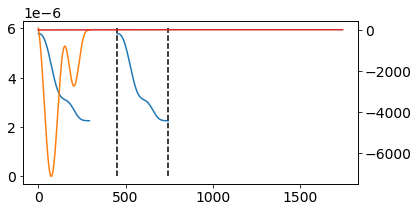

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.152005
Initial Pressure (kPa) = 2.636622
[455 693]
MLSi20HV7kV1Hz inital air volume = 6.152005 mL
MLSi20HV7kV1Hz avg. pressure loss = -3.43 kPa


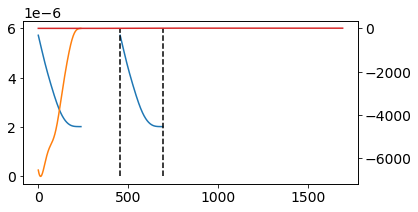

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.161067
Initial Pressure (kPa) = 2.262940
[355 708]
MLSi20HV7kV1Hz inital air volume = 6.161067 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.48 kPa


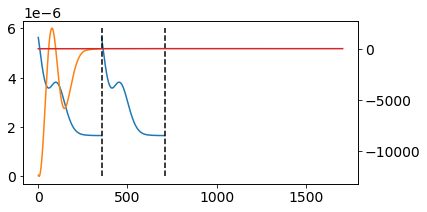

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.128276
Initial Pressure (kPa) = 2.240487
[412 769]
MLSi20HV7kV1Hz inital air volume = 6.128276 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.44 kPa


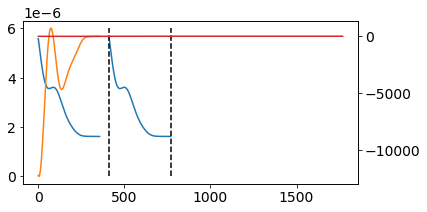

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.120101
Initial Pressure (kPa) = 2.185958
[490 843]
MLSi20HV7kV1Hz inital air volume = 6.120101 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.48 kPa


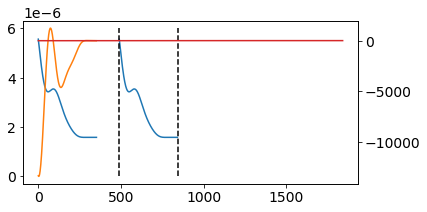

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.168340
Initial Pressure (kPa) = 2.221241
[489 837]
MLSi20HV7kV1Hz inital air volume = 6.168340 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.52 kPa


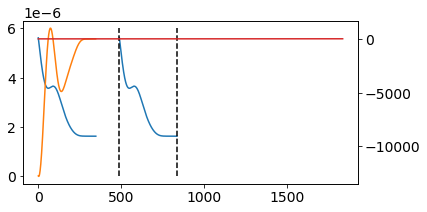

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.099798
Initial Pressure (kPa) = 2.104165
[552 906]
MLSi20HV7kV1Hz inital air volume = 6.099798 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.47 kPa


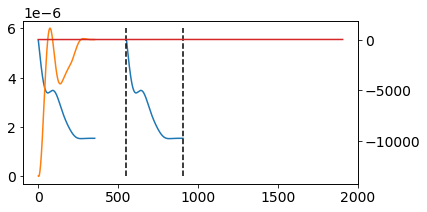

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.163568
Initial Pressure (kPa) = 2.141052
[640 987]
MLSi20HV7kV1Hz inital air volume = 6.163568 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.52 kPa


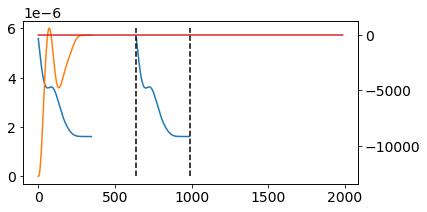

red: PressSig_kPa, orange:PiLoss, blue: zippingVi
Initial Volume (mL) = 6.131846
Initial Pressure (kPa) = 2.168317
[ 715 1066]
MLSi20HV7kV1Hz inital air volume = 6.131846 mL
MLSi20HV7kV1Hz avg. pressure loss = -2.47 kPa


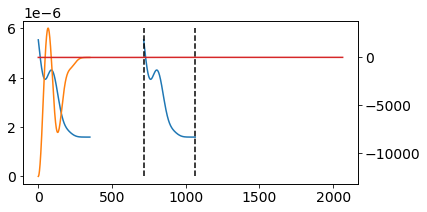

red: PressSig_kPa, orange:PiLoss, blue: zippingVi


In [19]:
''' Both Simulation and Measurement Data required '''

sigData['V0'] = 0

avgPressLoss = []
for i in sigData.index:
    deltaVolume = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'dV1Expan_m3'].iloc[0]

    sigData.loc[i,'V0'] = deltaVolume / (1 - pressData.loc[i,'P0_kPa']/pressData.loc[i,'MaxPressure_kPa']) # Unit: m3
    
    print("Initial Volume (mL) = %f" % (sigData.loc[i,'V0']*1e6))
    print("Initial Pressure (kPa) = %f" % pressData.loc[i,'P0_kPa'])
    print(sigData.loc[i,'SegIndex'])
    
    print("%s inital air volume = %.6f mL" % (sigData.loc[i,'CondiName'], sigData.loc[i,'V0']*1e6)) 
    
    ''' Realtime volume '''
    Vi = sigData.loc[i,'V0'] * pressData.loc[i,'P0_kPa'] / (sigData.loc[i,'PressSig_kPa'] + 1e-3) # Unit: m3
    
    zippingVi = Vi[sigData.loc[i,'SegIndex'][0]:sigData.loc[i,'SegIndex'][1]] # Unit: m3
    
    zippingVi = lowpassFilter(zippingVi, 20, Fs, 8) # Smooth volume change before differentiation
    
    ''' Realtime volume flow rate '''
    Qi = np.diff(zippingVi) * Fs # Unit: m3/s
    
    PiLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * Qi
    
    avgPLoss = np.mean(PiLoss)*1e-3 # Unit: kPa
    print("%s avg. pressure loss = %.2f kPa" % (sigData.loc[i,'CondiName'], avgPLoss))
    avgPressLoss.append(avgPLoss)
    
    ax,_=aPlot()
    ax.plot(zippingVi)
    ax.plot(np.arange(sigData.loc[i,'SegIndex'][0], sigData.loc[i,'SegIndex'][1]), zippingVi,'tab:blue')
    ax.plot([sigData.loc[i,'SegIndex'][0],sigData.loc[i,'SegIndex'][0]], [0, 6e-6], '--k')
    ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, 6e-6], '--k')
# #     ax.set_ylim([0, 6e-6]);
    ax2 = ax.twinx() 
    ax2.plot(PiLoss,color='tab:orange')
    ax2.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
    plt.show();
    print("red: PressSig_kPa, orange:PiLoss, blue: zippingVi")
    

pressData['P1ExpanLoss_kPa'] = avgPressLoss
# pressData.to_csv("Measurements.csv") 